## Байесовские модели возраста/периода/когорты на Python с помощью PyMC

**[вольный перевод](https://austinrochford.com/posts/apc-pymc.html#)**

Приведем пример APC (age-period-cohort) модели. 
Данные модели широко применяются для анализа в эпидемиологии, социологии и демографии, в том числе для изучения динамики рождаемости. 

Эти модели также создают некоторые интересные проблемы с выводами для недостаточно аккурвтных исследователей. 

Здесь показано, как использовать pymc для построения байесовских моделей APC на Python, и представлена серия все более усложняющихся систем априорных значений для решения проблем, связанных с выводом, которые создают эти модели.

Сначала мы производим необходимый импорт Python и выполняем небольшую подготовительную работу работу.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import arviz as az
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy as sp
import seaborn as sns
from IPython.display import display

In [3]:
plt.rc("figure", figsize=(8, 6))
sns.set(color_codes=True)

## Загрузка данных данные

Мы используем данные [общеамериканских социологических опросов](https://vincentarelbundock.github.io/Rdatasets/doc/AER/GSS7402.html) за 1974-2002 годы. Этот набор данных доступен в превосходном репозитории Rdatasets Винсента Ареля-Бандока и изначально взят [из пакета AER (Applied Econometrics with R)](https://cran.r-project.org/web/packages/AER/index.html) для R.

In [4]:
DATA_URL = "GSS7402.csv"

In [5]:
df = (pd.read_csv(DATA_URL, usecols=["kids", "age", "year"])
        [["age", "year", "kids"]])
display(df.head())
display(df.tail())

,age,year,kids
0,25,2002,0
1,30,2002,1
2,55,2002,1
3,57,2002,2
4,71,2002,2


,age,year,kids
9115,30,1998,3
9116,37,1998,2
9117,59,1998,3
9118,73,1998,2
9119,40,1998,0


## EDA анализ

Столбцами этого фрейма данных являются

- возраст: возраст, в котором женщина была опрошена,
- год: год, в котором женщина была опрошена,
- дети: количество детей, которые были у женщины на момент опроса.

Эти столбцы содержат всю информацию, необходимую нам для построения модели APC-модели о том, как менялось среднее число детей в зависимости от возраста женщины, года и даты ее рождения. Очевидно, что столбец `age` соответствует компоненту "возраст" модели APC-модели, а столбец `year` соответствует компоненту "период" APC-модели. 
Для этого набора данных компонент "когорта" соответствует году, в котором женщина родила, который  рассчитывается как разница между возрастом женщины и текущим годом.

In [6]:
df["cohort"] = df["year"] - df["age"]
df.head()

,age,year,kids,cohort
0,25,2002,0,1977
1,30,2002,1,1972
2,55,2002,1,1947
3,57,2002,2,1945
4,71,2002,2,1931


Именно эта линейная взаимосвязь между возрастом, годом и когортой вызываю проблемы в  APC-модели .

Следующие графики показывают, как среднее число детей у женщин меняется в зависимости от возраста, периода (года) и когорты.

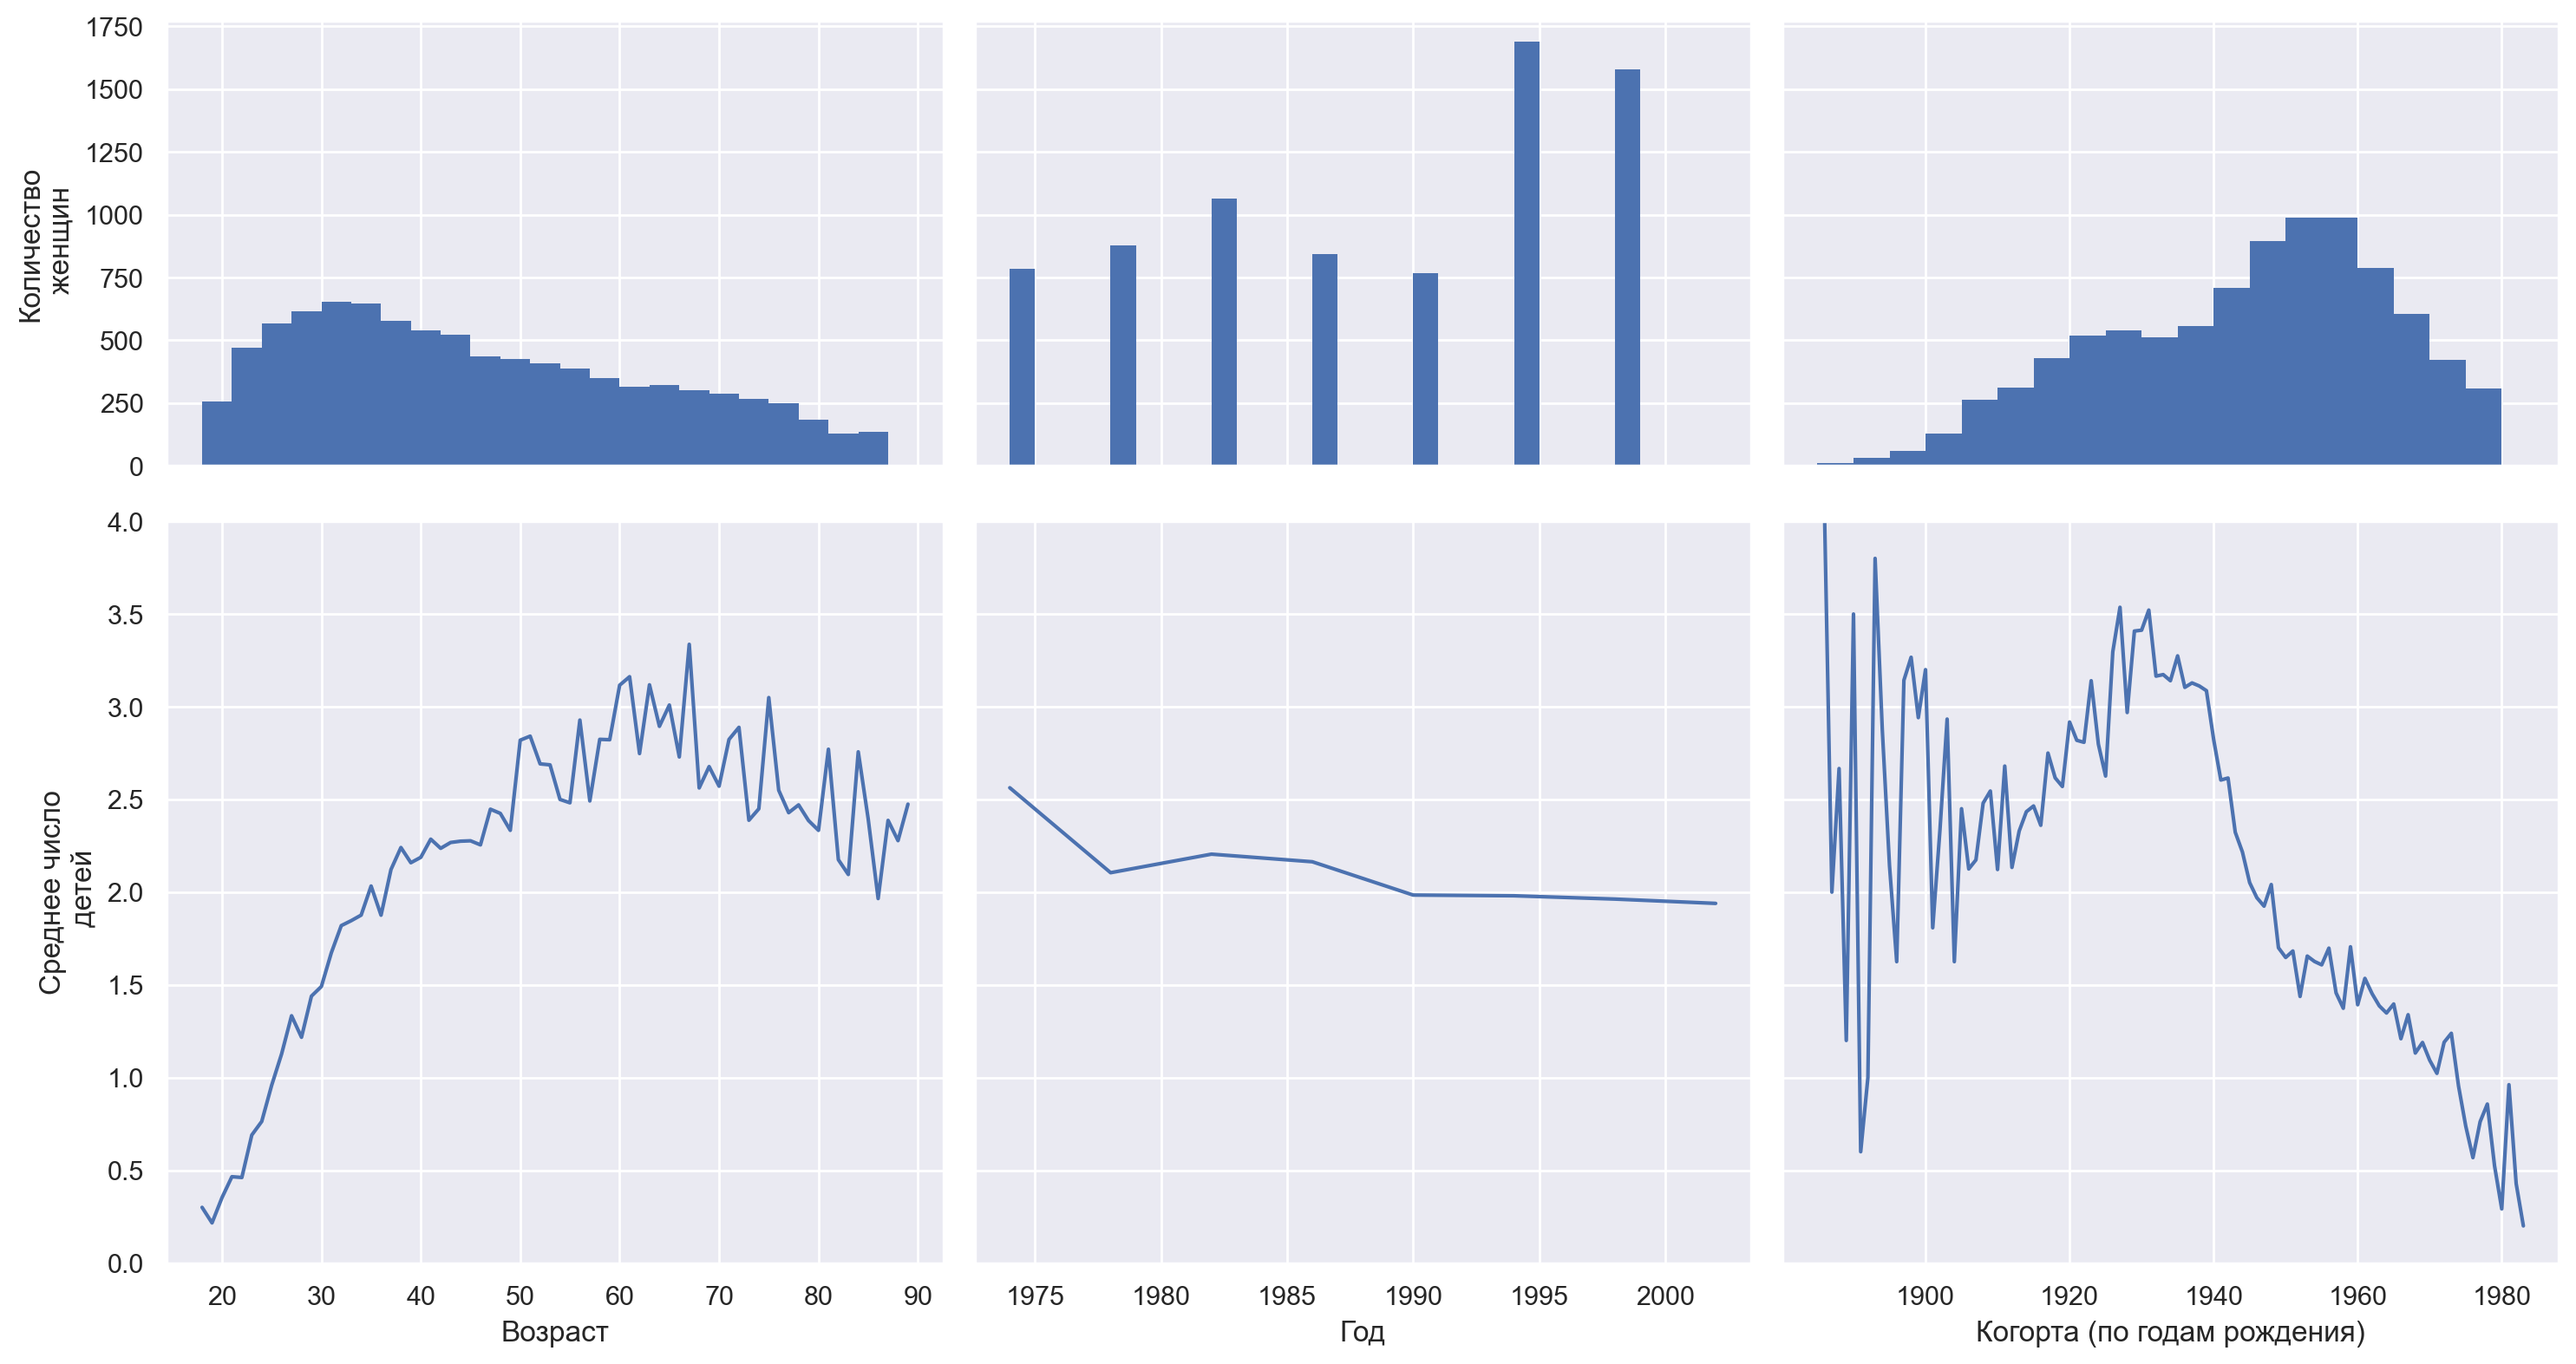

In [7]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 8),
                         gridspec_kw={"height_ratios": (3, 5)})

axes[0, 0].sharex(axes[1, 0]);
axes[0, 1].sharex(axes[1, 1]);
axes[0, 2].sharex(axes[1, 2]);

axes[0, 0].sharey(axes[0, 1]);
axes[0, 1].sharey(axes[0, 2]);

axes[1, 0].sharey(axes[1, 1]);
axes[1, 1].sharey(axes[1, 2]);

# age

axes[0, 0].hist(
    df["age"],
    bins=np.arange(df["age"].min(), df["age"].max() - 1, 3),
    lw=0
);

axes[0, 0].set_ylabel("Количество\n женщин");

(df.groupby("age")
        ["kids"]
        .mean()
        .plot(ax=axes[1, 0]));

axes[1, 0].set_xlabel("Возраст");
axes[1, 0].set_ylabel("Среднее число\n детей");

# year

axes[0, 1].hist(
    df["year"],
    bins=np.arange(df["year"].min(), df["year"].max() - 1),
    lw=0
);

(df.groupby("year")
        ["kids"]
        .mean()
        .plot(ax=axes[1, 1]));

axes[1, 1].set_xlabel("Год");

# cohort

axes[0, 2].hist(
    df["cohort"],
    bins=np.arange(df["cohort"].min(), df["cohort"].max() - 1, 5),
    lw=0
);

(df.groupby("cohort")
        ["kids"]
        .mean()
        .plot(ax=axes[1, 2]));

axes[1, 2].set_xlabel("Когорта (по годам рождения)");
axes[1, 2].set_ylim(0, 4);

fig.tight_layout();

Взаимосвязь с возрастом неудивительна: на протяжении двадцатых и тридцатых годов среднее число детей увеличивается относительно стабильными темпами, а затем выравнивается начиная с сороковых годов. 

Наиболее примечательной особенностью соотношения периодов является то, что оно относительно невелико по сравнению с соотношением возраста и когорты. 

Отношения с когортой, пожалуй, самые интересные. Год рождения женщины определяет, когда она вступает в период наилучшего деторождения - от двадцати до сорока лет, поэтому пики и спады в когортных соотношениях примерно соответствуют экономическим и социальным условиям, когда женщины в этой когорте находятся в наилучшем детородном возрасте.

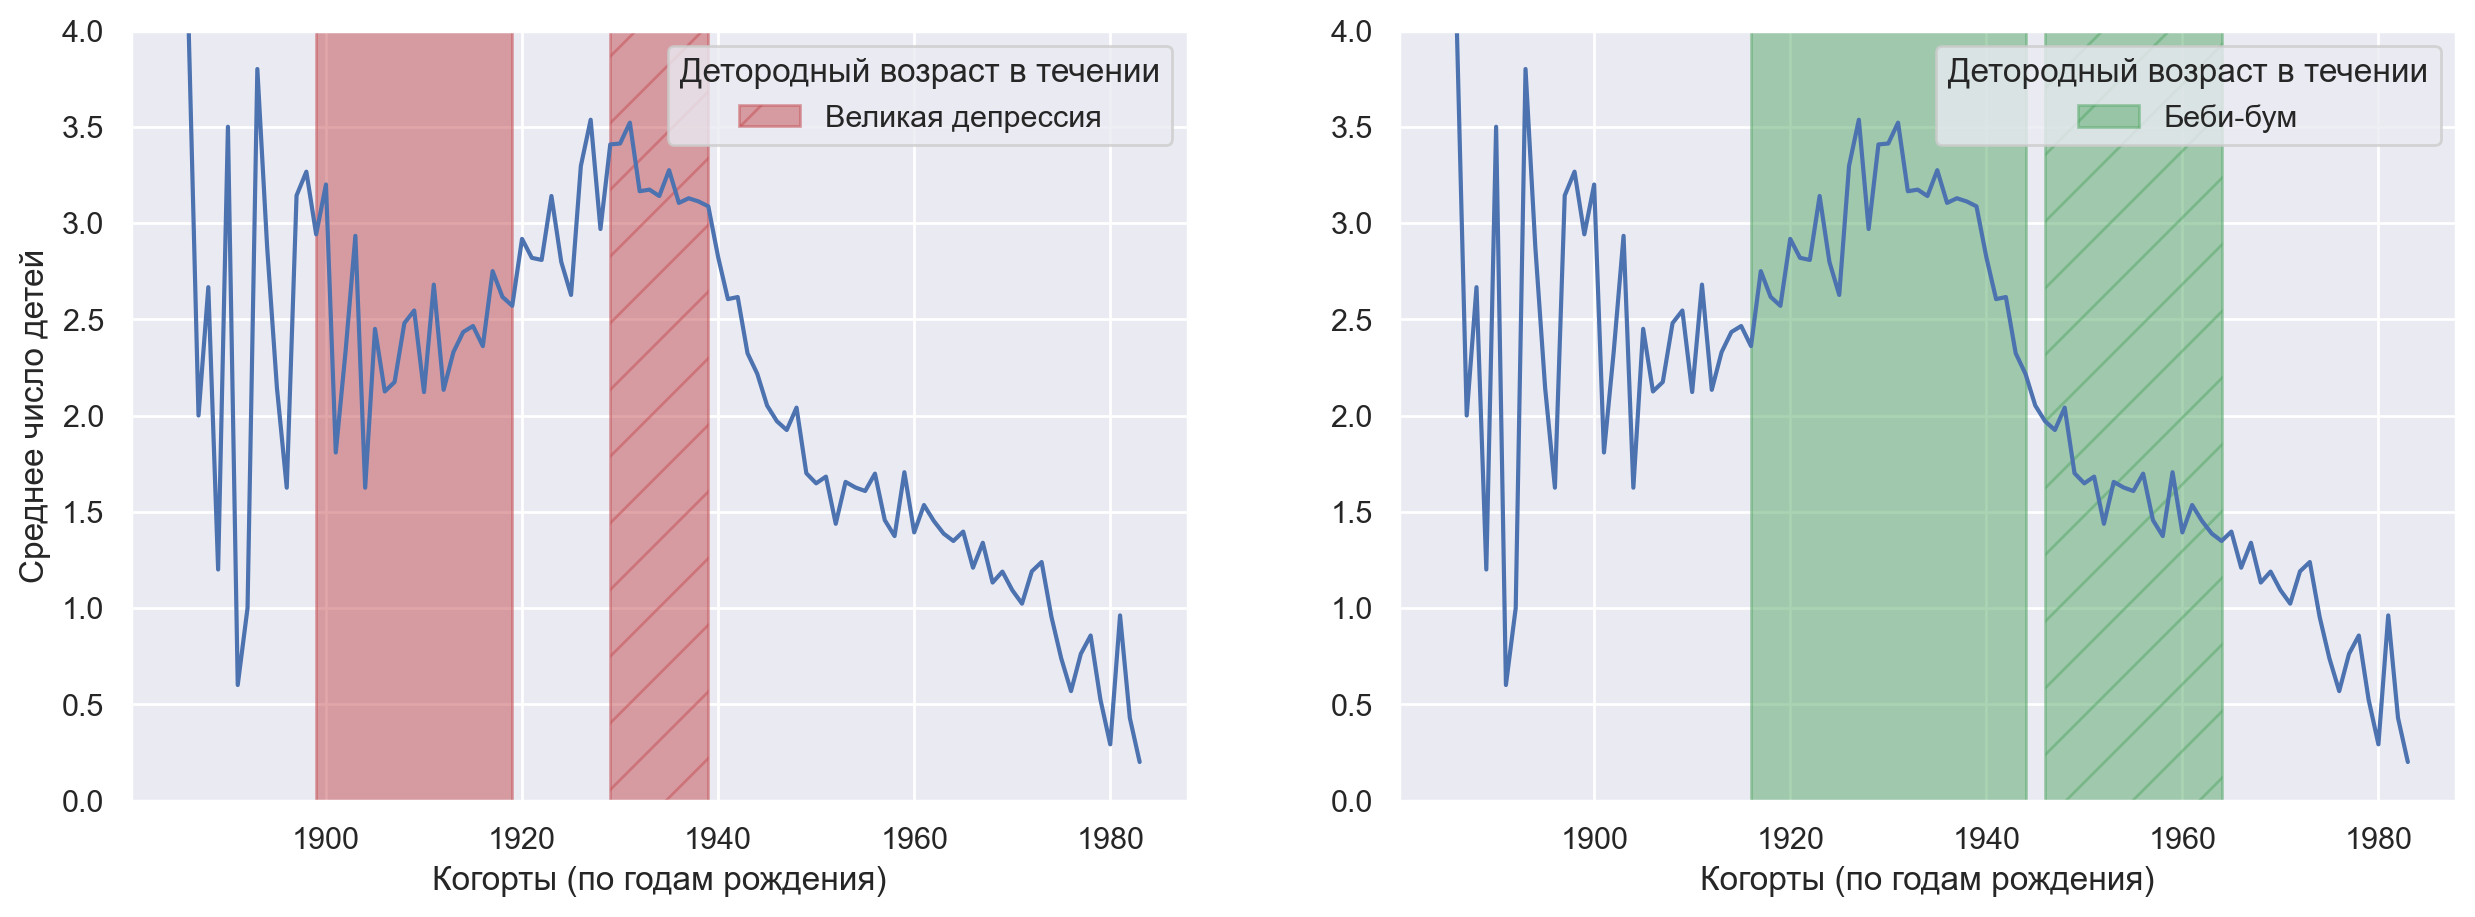

In [8]:
GREAT_DEPRESSION = np.array([1929, 1939])
BABY_BOOM = np.array([1946, 1964])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))

ax1.axvspan(GREAT_DEPRESSION[0], GREAT_DEPRESSION[1], 
           color="C3", alpha=0.5, label="Великая депрессия", hatch = "/")

ax1.axvspan(GREAT_DEPRESSION[0] - 30, GREAT_DEPRESSION[1] - 20,
            color="C3", alpha=0.5);

ax2.axvspan(BABY_BOOM[0], BABY_BOOM[1], 
           color="C2", alpha=0.5, label="Беби-бум", hatch = "/")

ax2.axvspan(BABY_BOOM[0] - 30, BABY_BOOM[1] - 20,
            color="C2", alpha=0.5);

plot_g = df.groupby("cohort")["kids"].mean()
plot_g.plot(label="_nolegend_", ax=ax1);
plot_g.plot(label="_nolegend_", ax=ax2);

ax1.set_xlabel("Когорты (по годам рождения)");
ax2.set_xlabel("Когорты (по годам рождения)");

ax1.set_ylim(0, 4);
ax2.set_ylim(0, 4);
ax1.set_ylabel("Среднее число детей");

ax1.legend(loc="upper right", title="Детородный возраст в течении");
ax2.legend(loc="upper right", title="Детородный возраст в течении");

При более внимательном рассмотрении когортных соотношений мы видим, что первая впадина соответствует женщинам, которые рожали бы большинство своих детей во время Великой депрессии, а последующий пик соответствует женщинам, рожавшим детей во время бэби-бума после Второй мировой войны.

Взяв вместе эти данные, разумно предположить, что биологических факторов, связанных с возрастом, и социально-экономических факторов, связанных с когортой, достаточно для объяснения различий в количестве детей без учета периода (года). Модели APC, которые мы построим в этом посте, позволят нам оценить достоверность этой гипотезы.

На данный момент важно отметить, что я не демограф, и даже если бы я им был, лучше не делать глубоких демографических выводов из любого анализа, проведенного на основе этого набора данных. Цель этого поста - использовать этот набор данных в качестве простого примера, чтобы проиллюстрировать некоторые тонкости, связанные с выводом с использованием моделей APC.

**Определимся с дисперсией** 

Поскольку число детей дискретно, мы проверяем величину дисперсии, чтобы определить, какое распределение вероятностей лучше всего подходит для его моделирования.

In [9]:
def index_of_dispersion(x):
    return x.var() / x.mean()
index_of_dispersion(df["kids"])

1.5694754102397788

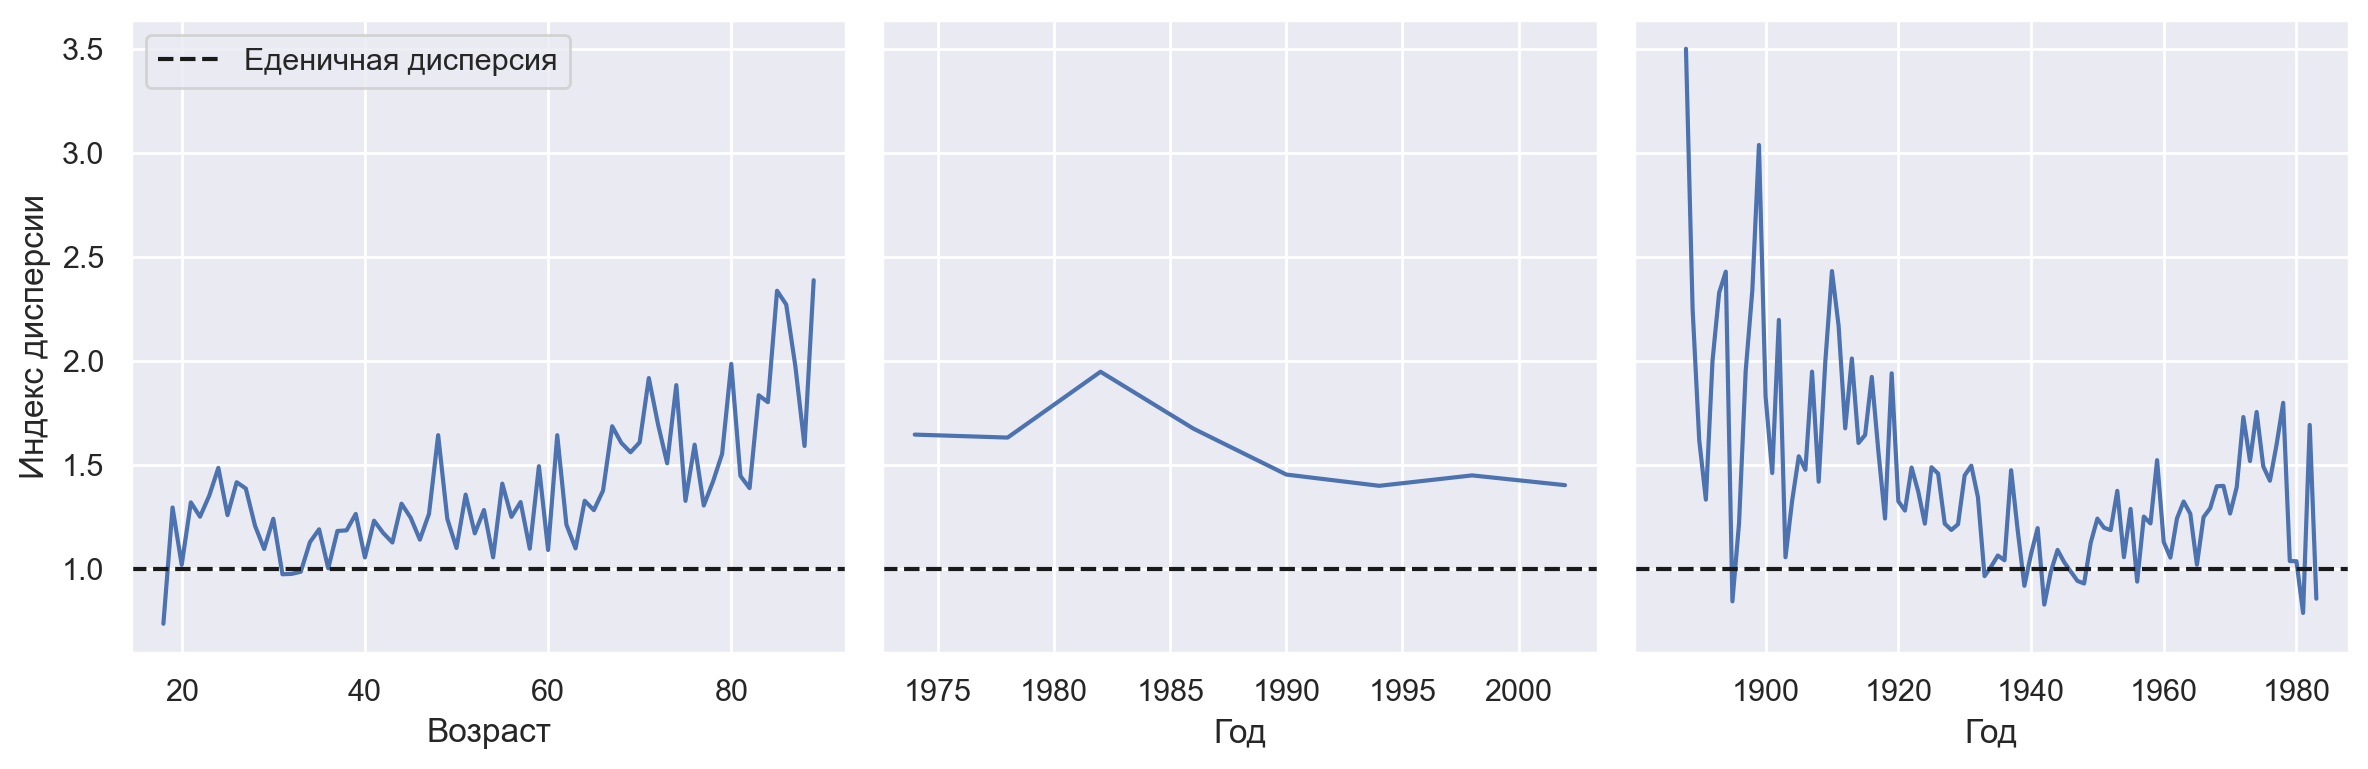

In [10]:
fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(12, 4))

index_of_dispersion(df.groupby("age")["kids"]).plot(label="_nolegend_", ax=axes[0]);
axes[0].axhline(1, c="k", ls="--", label="Еденичная дисперсия");

axes[0].set_xlabel("Возраст");
axes[0].set_ylabel("Индекс дисперсии");
axes[0].legend(loc="upper left");

index_of_dispersion(df.groupby("year")["kids"]).plot(ax=axes[1]);
axes[1].axhline(1, c="k", ls="--");
axes[1].set_xlabel("Год");

index_of_dispersion(df.groupby("cohort")["kids"]).plot(ax=axes[2]);
axes[2].axhline(1, c="k", ls="--");
axes[2].set_xlabel("Год");

fig.tight_layout();

## Модель

Построим APC-модель зависимости количества  детей. Напомним, что если $X \sim \text{NB}(\mu_x, \nu)$ и $Y \sim \text{NB}(\mu_y, \nu)$, то $X+Y \sim \text{NB}(\mu_x+\mu_y, \nu)$. Где $\text{NB}$ - [отрицательное биномиальное распределение](https://ru.wikipedia.org/wiki/Отрицательное_биномиальное_распределение)
Используя этот факт, мы уменьшаем размер наблюдаемых данных в нашей модели, группируя каждое наблюдение по возрастной/периодической/когортной комбинации, подсчитывая количество женщин с такой комбинацией и суммируя количество их детей.

In [11]:
apc_df = (df.groupby(["age", "year", "cohort"])["kids"].agg(("size", "sum")))
apc_df 

size  sum
age year cohort           
18  1974 1956       3    2
    1978 1960       7    3
    1982 1964       2    0
    1986 1968       1    0
    1990 1972       2    0
...               ...  ...
89  1986 1897       5   10
    1990 1901       8   11
    1994 1905      14   35
    1998 1909      10   31
    2002 1913       9   11

[571 rows x 2 columns]

In [12]:
N = apc_df["size"].values
kids = apc_df["sum"].values

Где `apc_df["size"]` and `N` количество женщин, опрошенных в этом конкретном возрасте/периоде/когортной комбинации, а `apc_df["sum"]` и `kids` их общее количество детей.

Для удобства мы кодируем  `age`, `year`, and `cohort` как порядковые коэффициенты.

In [13]:
i, age_map = apc_df.index.get_level_values("age").factorize(sort=True)
j, year_map = apc_df.index.get_level_values("year").factorize(sort=True)
k, cohort_map = apc_df.index.get_level_values("cohort").factorize(sort=True)

Теперь мы готовы построить нашу первую модель APC, которая будет использовать плоские априорные значения для эффектов возраста, периода и когорты. На протяжении всего этого поста пусть $i$ обозначает возраст выборки, $j$ обозначает ее период и $k$ обозначает ее когорту. Все наши модели будут иметь форму:
$$ \eta_{i,j,k} = \eta_0+\alpha_i+\beta_j+\gamma_k $$
$$y_{i,j,k} \sim \text{NB}\left(N_{i,j,k}\exp(\eta_{i,j,k}), \nu \right)  $$

Здесь $N_{i,j,k}$ - количество женщин в соответствующей комбинации возраста/периода/когорты, $y_{i,j,k}$ - общее количество детей, которых они имеют, и $\nu$ контролирует степень чрезмерного распространения. Обратите внимание, что это модель отрицательной биномиальной регрессии со смещенным членом.

Используя `pymc`, мы указываем плоские априорные распределения:
$$\pi(\eta_0), \pi(\alpha_i), \pi(\beta_i), \pi(\gamma_i) \propto 1$$

Применяем для $\nu \sim \text{Half Norm}(2.5)$, а спецификацию $\eta_{i,j,k}$ для получения правдоподобие.

In [14]:
coords = {
    "age": age_map,
    "year": year_map,
    "cohort": cohort_map
}

In [15]:
with pm.Model(coords=coords) as flat_model:
    η0 = pm.Flat("η0")
    α = pm.Flat("α", dims="age")
    β = pm.Flat("β", dims="year")
    γ = pm.Flat("γ", dims="cohort")    
    η = η0 + α[i] + β[j] + γ[k]
    ν = pm.HalfNormal("ν", 2.5)
    
    pm.NegativeBinomial("kids", N * pm.math.exp(η), ν, observed=kids)
    
    flat_trace = pm.sample(chains = 4,  cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η0, α, β, γ, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 473 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [16]:
az.summary(flat_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
η0,20.796,86.198,-127.286,152.029,40.512,30.726,5.0,13.0,2.52
α[18],7.067,11.792,-7.299,25.601,5.868,4.493,4.0,15.0,3.22
α[19],-2.063,3.334,-5.721,3.952,1.653,1.265,4.0,12.0,3.24
α[20],1.155,4.631,-5.578,7.774,2.303,1.763,5.0,15.0,3.06
α[21],1.959,5.271,-5.637,9.632,2.622,2.007,4.0,17.0,3.19
...,...,...,...,...,...,...,...,...,...
γ[1980],-8.104,6.764,-18.124,0.798,3.359,2.571,4.0,12.0,3.21
γ[1981],-1.469,7.398,-13.780,7.689,3.678,2.816,5.0,20.0,2.67
γ[1982],-1.509,5.469,-11.104,4.800,2.710,2.073,5.0,30.0,2.86
γ[1983],0.860,11.140,-15.625,14.027,5.536,4.238,5.0,27.0,2.89


Как гласит ["народная" теорема байесовского анализа](https://statmodeling.stat.columbia.edu/2008/05/13/the_folk_theore/):
    
***Когда у вас возникают вычислительные проблемы, их возникновение обычно связано с проблемами в вашей модели.***

### Регурялизованная модель

Регуляризация - это распространенный подход к решению проблем мультиколлиниарности 
модели. С байесовской точки зрения регуляризация эквивалентна использованию 
неплоских априорных значений для наших параметров $\eta_0,\alpha_i,\beta_j,\gamma_k$. 
Разумно начать с нормально распределенных предварительных данных по этим параметрам. Эти нормальные априорные распределения, по сути, эквивалентны регуляризации Тихонова/гребневой регрессии.
таким образом в нашей модели:
 $$\eta_0,\alpha_i,\beta_j,\gamma_k \sim N(0, \sigma_\alpha)$$


In [17]:
with pm.Model(coords=coords) as norm_model:
    η0 = pm.Normal("η0", 0, 2.5)
    α = pm.Normal("α", 0, 2.5, dims="age")
    β = pm.Normal("β", 0, 2.5, dims="year")
    γ = pm.Normal("γ", 0, 2.5, dims="cohort")
    η = η0 + α[i] + β[j] + γ[k]
    
    ν = pm.HalfNormal("ν", 2.5)
    pm.NegativeBinomial("kids", N * pm.math.exp(η), ν, observed=kids)
    
    norm_trace = pm.sample(chains = 4,  
                         cores = 4, idata_kwargs={'log_likelihood':True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η0, α, β, γ, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 171 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


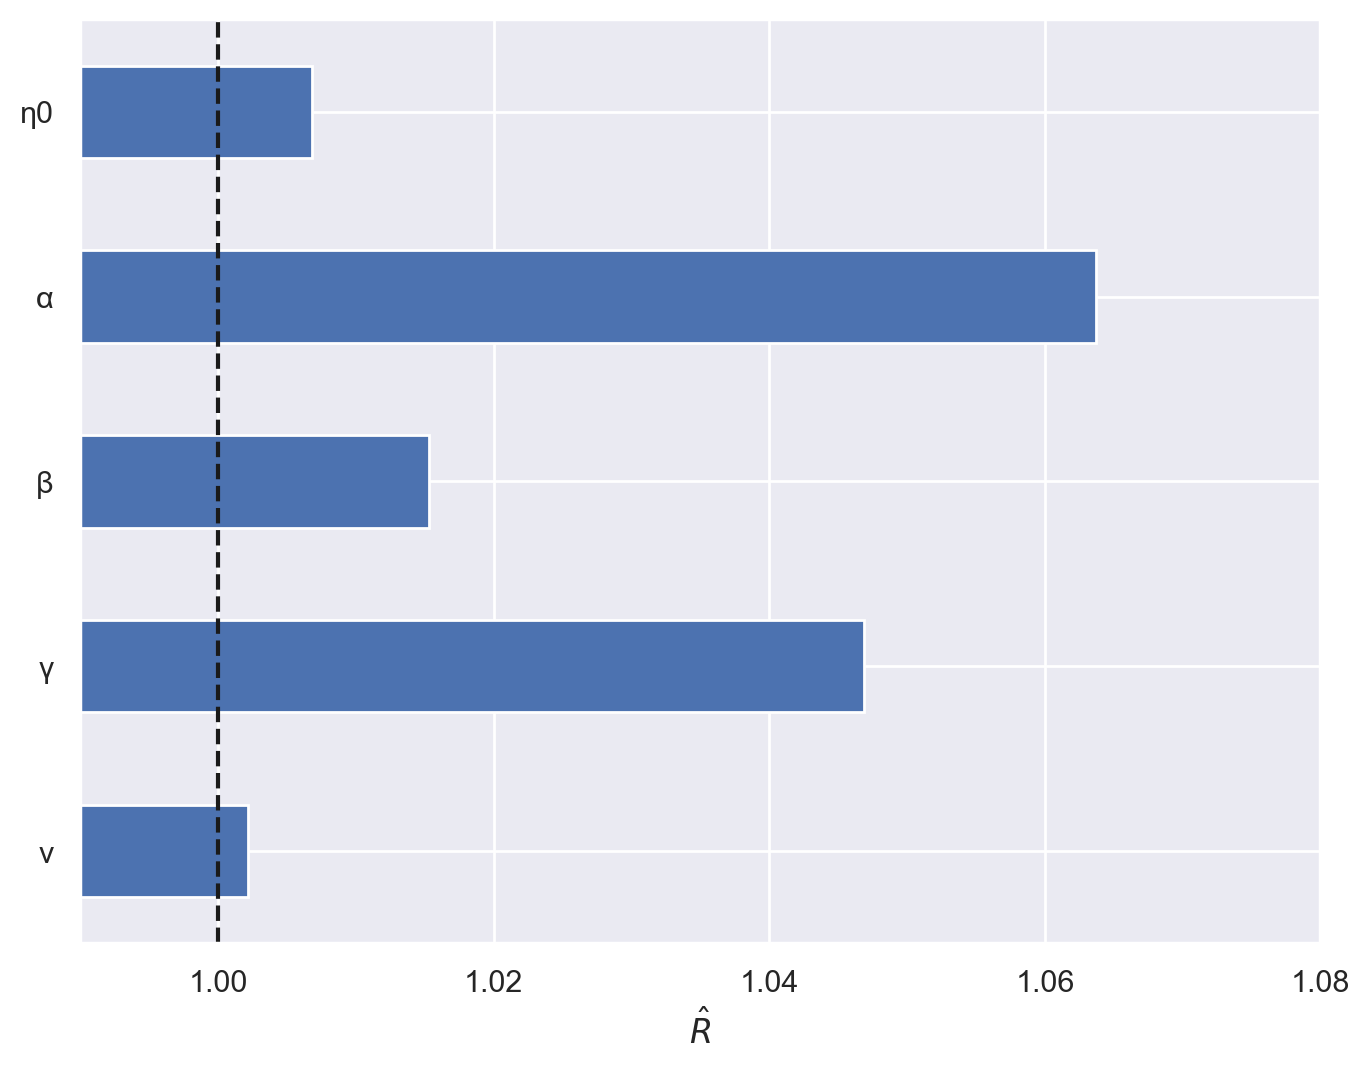

In [18]:
norm_rhat = az.rhat(norm_trace)
ax = (norm_rhat.max()
               .to_array()
               .to_series()
               .plot(kind="barh"))
ax.axvline(1, c="k", ls="--");

ax.set_xlim(0.99, 1.08);
ax.set_xlabel(r"$\hat{R}$");

ax.invert_yaxis();
ax.set_ylabel(None);

Мы видим, что в целом предупреждений меньше, чем при выборке из плоской модели, но по-прежнему существуют проблемы сходимости моделей. Статистика $\hat{R}$ намного ближе к идеальному значению, равному единице, но все же больше, чем 1.01, поэтому нам следует по-прежнему скептически относиться к качеству этих выборок.

Для демонстрации проблем посмотрим априорные распределения для параметра с самой большой $\hat{R}$

In [19]:
norm_rhat

<xarray.Dataset>
Dimensions:  (age: 72, year: 8, cohort: 98)
Coordinates:
  * age      (age) int64 18 19 20 21 22 23 24 25 26 ... 82 83 84 85 86 87 88 89
  * year     (year) int64 1974 1978 1982 1986 1990 1994 1998 2002
  * cohort   (cohort) int64 1885 1887 1888 1889 1890 ... 1980 1981 1982 1983
Data variables:
    η0       float64 1.007
    α        (age) float64 1.015 1.041 1.032 1.028 ... 1.032 1.06 1.017 1.025
    β        (year) float64 1.011 1.011 1.012 1.013 1.014 1.014 1.014 1.015
    γ        (cohort) float64 1.015 1.016 1.014 1.014 ... 1.022 1.015 1.008
    ν        float64 1.002

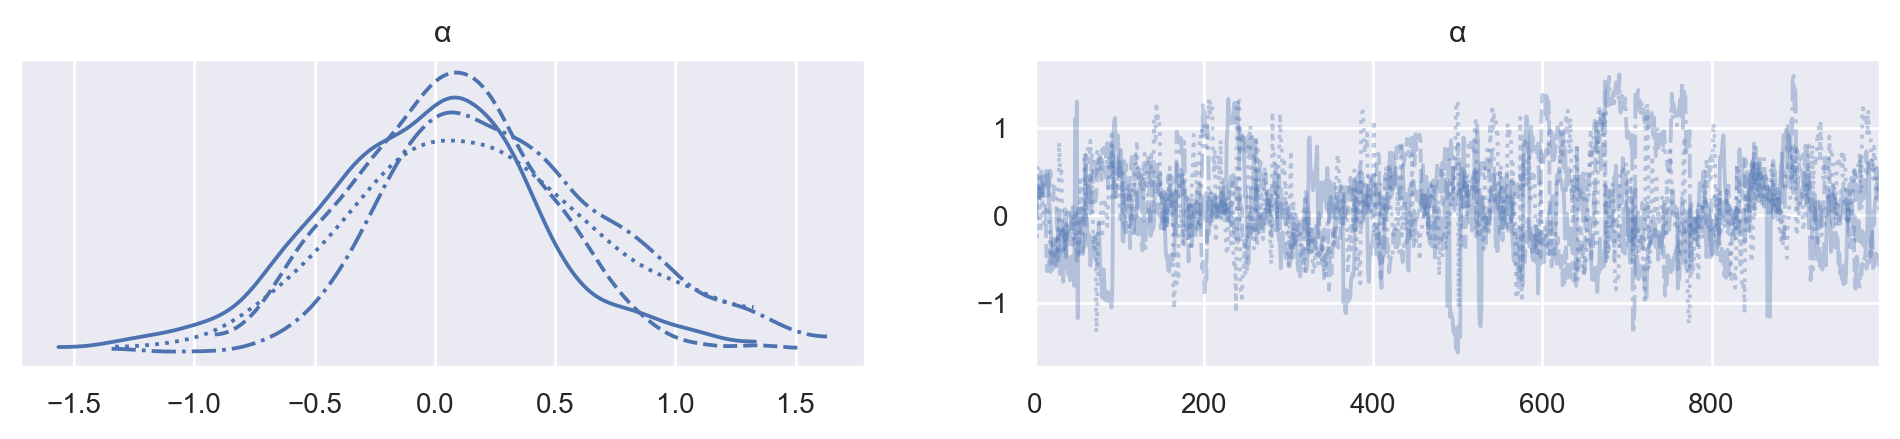

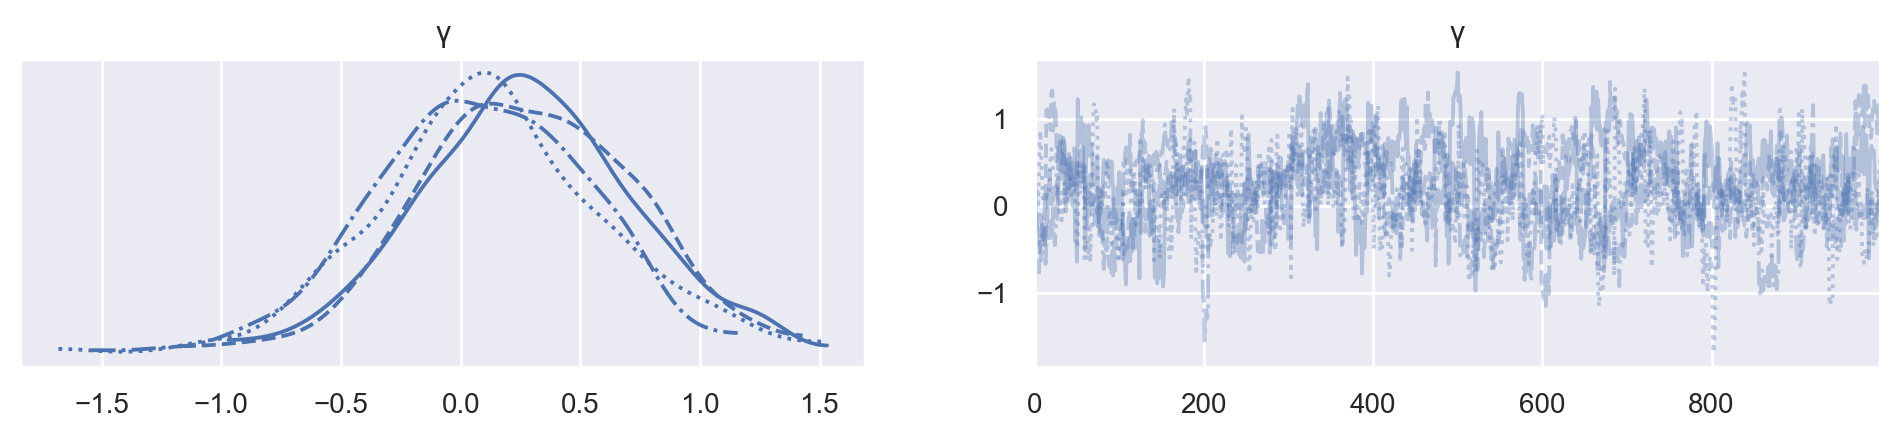

In [20]:
α_worst = norm_rhat["α"].idxmax()
az.plot_trace(norm_trace, var_names="α", coords={"age": α_worst});

γ_worst = norm_rhat["γ"].idxmax()
az.plot_trace(norm_trace, var_names="γ", coords={"cohort": γ_worst});

В оценках плотности ядра слева мы видим по крайней мере одну цепочку, которая "неслучайный вид".

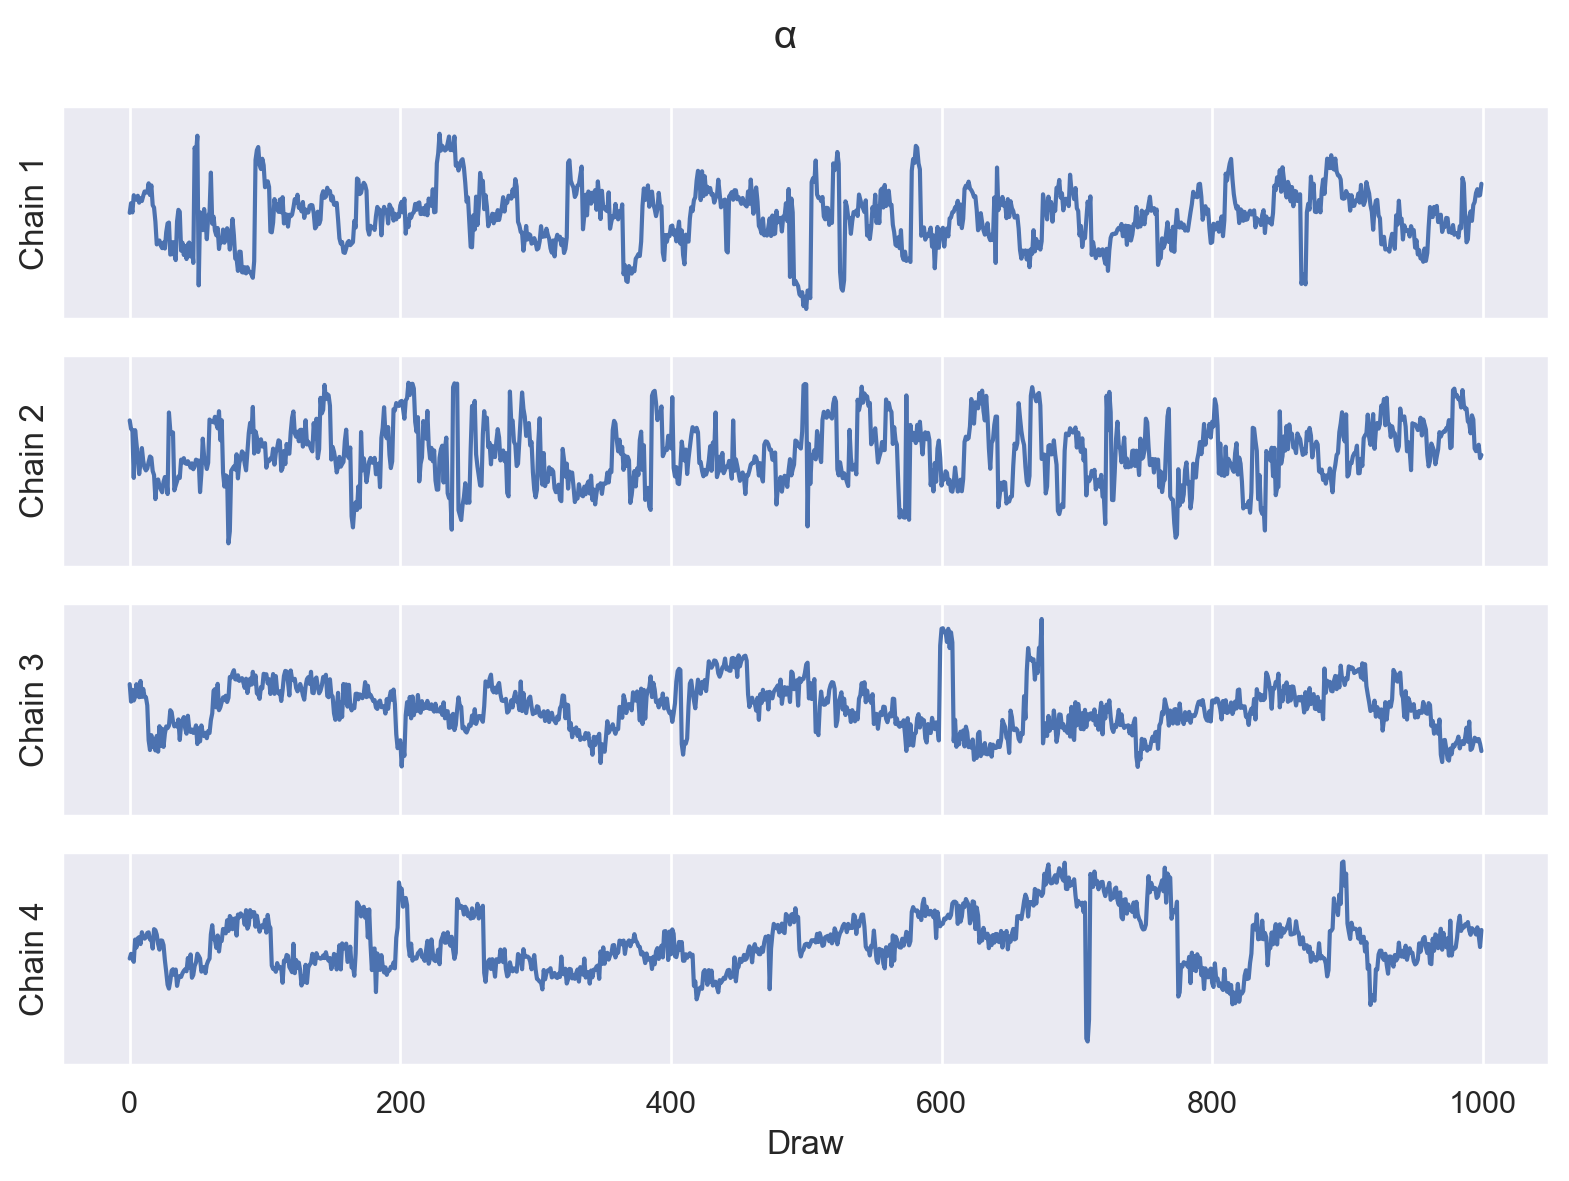

In [21]:
CHAINS = len(norm_trace.posterior['chain'].values)
fig, axes = plt.subplots(nrows=CHAINS, sharex=True, sharey=True)

for chain, ax in enumerate(axes):
    (norm_trace.posterior["α"]
               .sel(age=α_worst, chain=chain)
               .plot(ax=ax));
    
    ax.set_xlabel(None);
    
    ax.set_yticks([]);
    ax.set_ylabel(f"Chain {chain + 1}");
    
    ax.set_title(None);

axes[-1].set_xlabel("Draw");

fig.suptitle("α");
fig.tight_layout();

Построив для наглядности трассировку каждой цепочки отдельно, мы видим, что часть цепочек демонстрирует особенно тревожное поведение, производя относительно постоянные выборки в течение длительных периодов времени, а затем переходя к совершенно другим участкам пространства параметров.

Основываясь на этих результатах, мы видим, что введение регуляризации с помощью обычных априорных значений уменьшило, но не устранило проблемы с выводом в этой модели.

### Иерархическая модель

Модель APC с обычными приоритетами показывает, что добавление некоторой регуляризации помогает, поэтому для нашей следующей модели мы увеличиваем объем регуляризации. 

Мы сделаем это, устанавливая иерархические нормальные приоритеты для параметров APC.
 $$\alpha_i \sim N(0, \sigma_\alpha),\;\; \sigma_\alpha \sim \text{Half Norm}(2.5)$$
 $$\beta_i \sim N(0, \sigma_\beta),\;\;   \sigma_\beta  \sim \text{Half Norm}(2.5)$$
 $$\gamma_i \sim N(0, \sigma_\gamma),\;\; \sigma_\gamma \sim \text{Half Norm}(2.5)$$

In [22]:
# перемасштабирование, необходимое для получения полунормального распределения, 
# имеет единичную дисперсию

HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

def noncentered_normal(name, dims):
    Δ = pm.Normal(f"Δ_{name}", 0, 1, dims=dims)
    σ = pm.HalfNormal(f"σ_{name}", 2.5 * HALFNORMAL_SCALE)    
    return pm.Deterministic(name, Δ * σ, dims=dims)

In [23]:
with pm.Model(coords=coords) as nc_model:
    η0 = pm.Normal("η0", 0, 2.5)

    α = noncentered_normal("α", dims="age")
    β = noncentered_normal("β", dims="year")
    γ = noncentered_normal("γ", dims="cohort")
    
    η = η0 + α[i] + β[j] + γ[k]
    
    N_ = pm.MutableData("N", N)
    ν = pm.HalfNormal("ν", 2.5)
    pm.NegativeBinomial("kids", N_ * pm.math.exp(η), ν, observed=kids)
    
    nc_trace = pm.sample(target_accept=0.9, chains = 4,  cores = 4, idata_kwargs={'log_likelihood':True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η0, Δ_α, σ_α, Δ_β, σ_β, Δ_γ, σ_γ, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


In [24]:
az.summary(nc_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
η0,0.689,0.073,0.553,0.826,0.003,0.002,781.0,1547.0,1.0
Δ_α[18],-2.471,0.563,-3.519,-1.399,0.007,0.006,6001.0,2957.0,1.0
Δ_α[19],-3.693,0.465,-4.534,-2.791,0.010,0.007,2227.0,2251.0,1.0
Δ_α[20],-3.071,0.414,-3.835,-2.295,0.009,0.006,2224.0,3011.0,1.0
Δ_α[21],-2.715,0.388,-3.395,-1.978,0.008,0.006,2093.0,2538.0,1.0
...,...,...,...,...,...,...,...,...,...
γ[1979],-0.037,0.132,-0.289,0.209,0.002,0.002,7820.0,2778.0,1.0
γ[1980],-0.083,0.149,-0.384,0.182,0.002,0.002,7664.0,2647.0,1.0
γ[1981],0.138,0.147,-0.141,0.405,0.002,0.002,6091.0,2441.0,1.0
γ[1982],0.001,0.142,-0.269,0.272,0.002,0.002,8775.0,2752.0,1.0


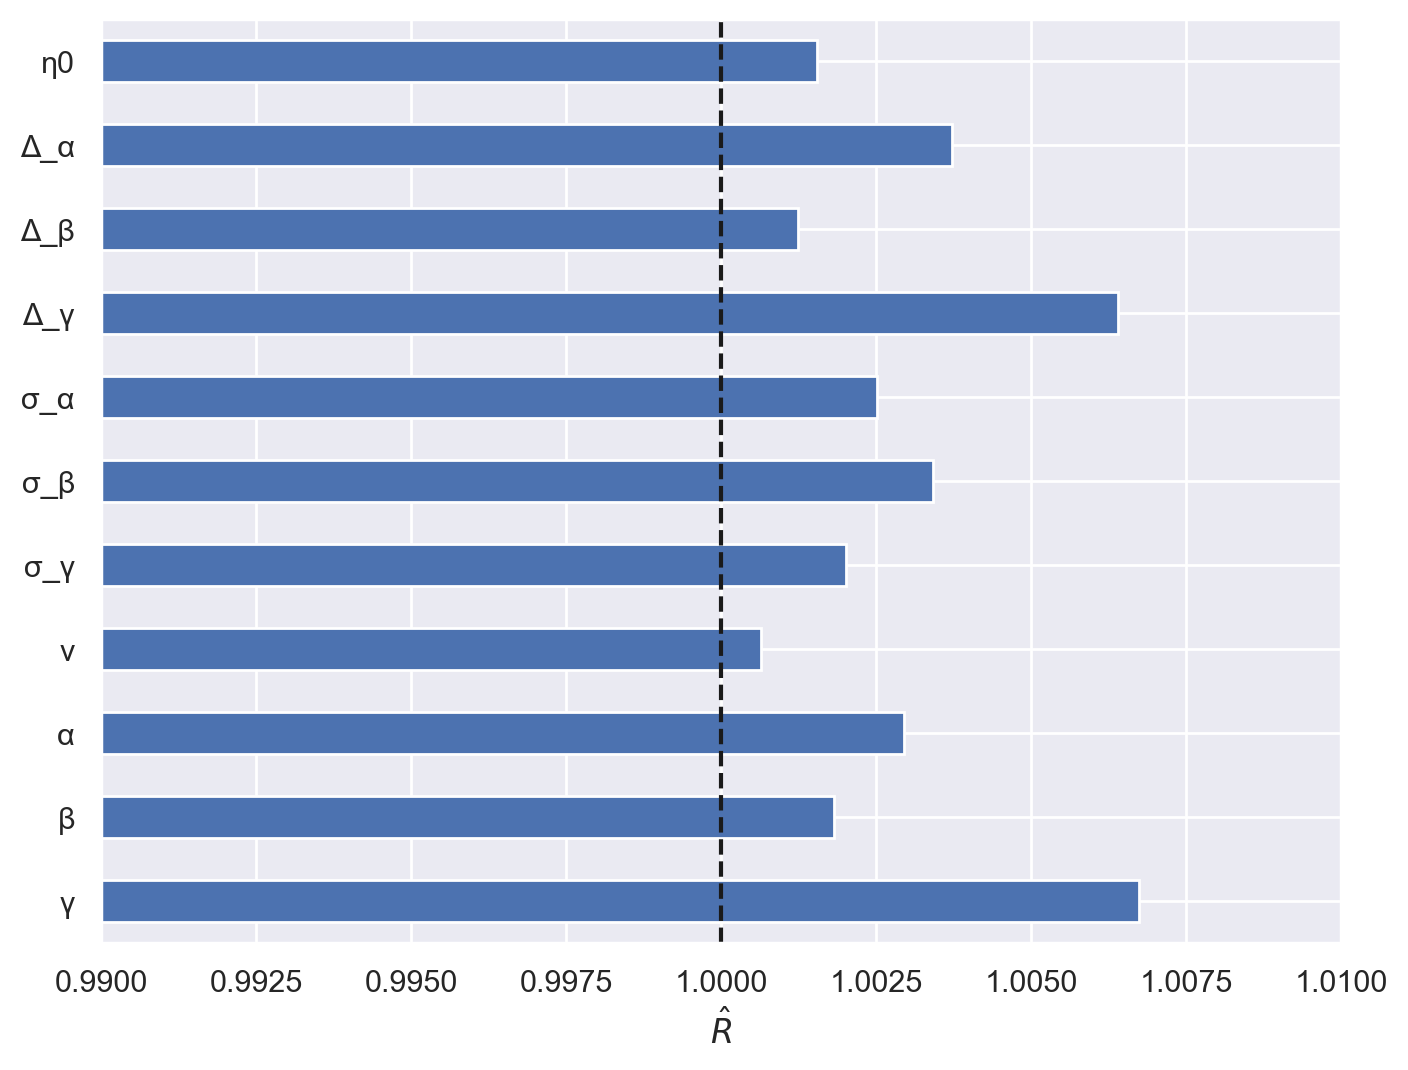

In [25]:
nc_rhat = az.rhat(nc_trace)
ax = (nc_rhat.max()
             .to_array()
             .to_series()
             .plot(kind="barh"))
ax.axvline(1, c="k", ls="--");

ax.set_xlim(0.99, 1.01);
ax.set_xlabel(r"$\hat{R}$");

ax.invert_yaxis();
ax.set_ylabel(None);

In [26]:
N_PP = 10_000 

def scale_pp(x):
    return x / N_PP

In [27]:
with nc_model:
    pm.set_data({"N": np.full_like(N, N_PP)})
    nc_trace.extend(pm.sample_posterior_predictive(nc_trace))

Sampling: [kids]


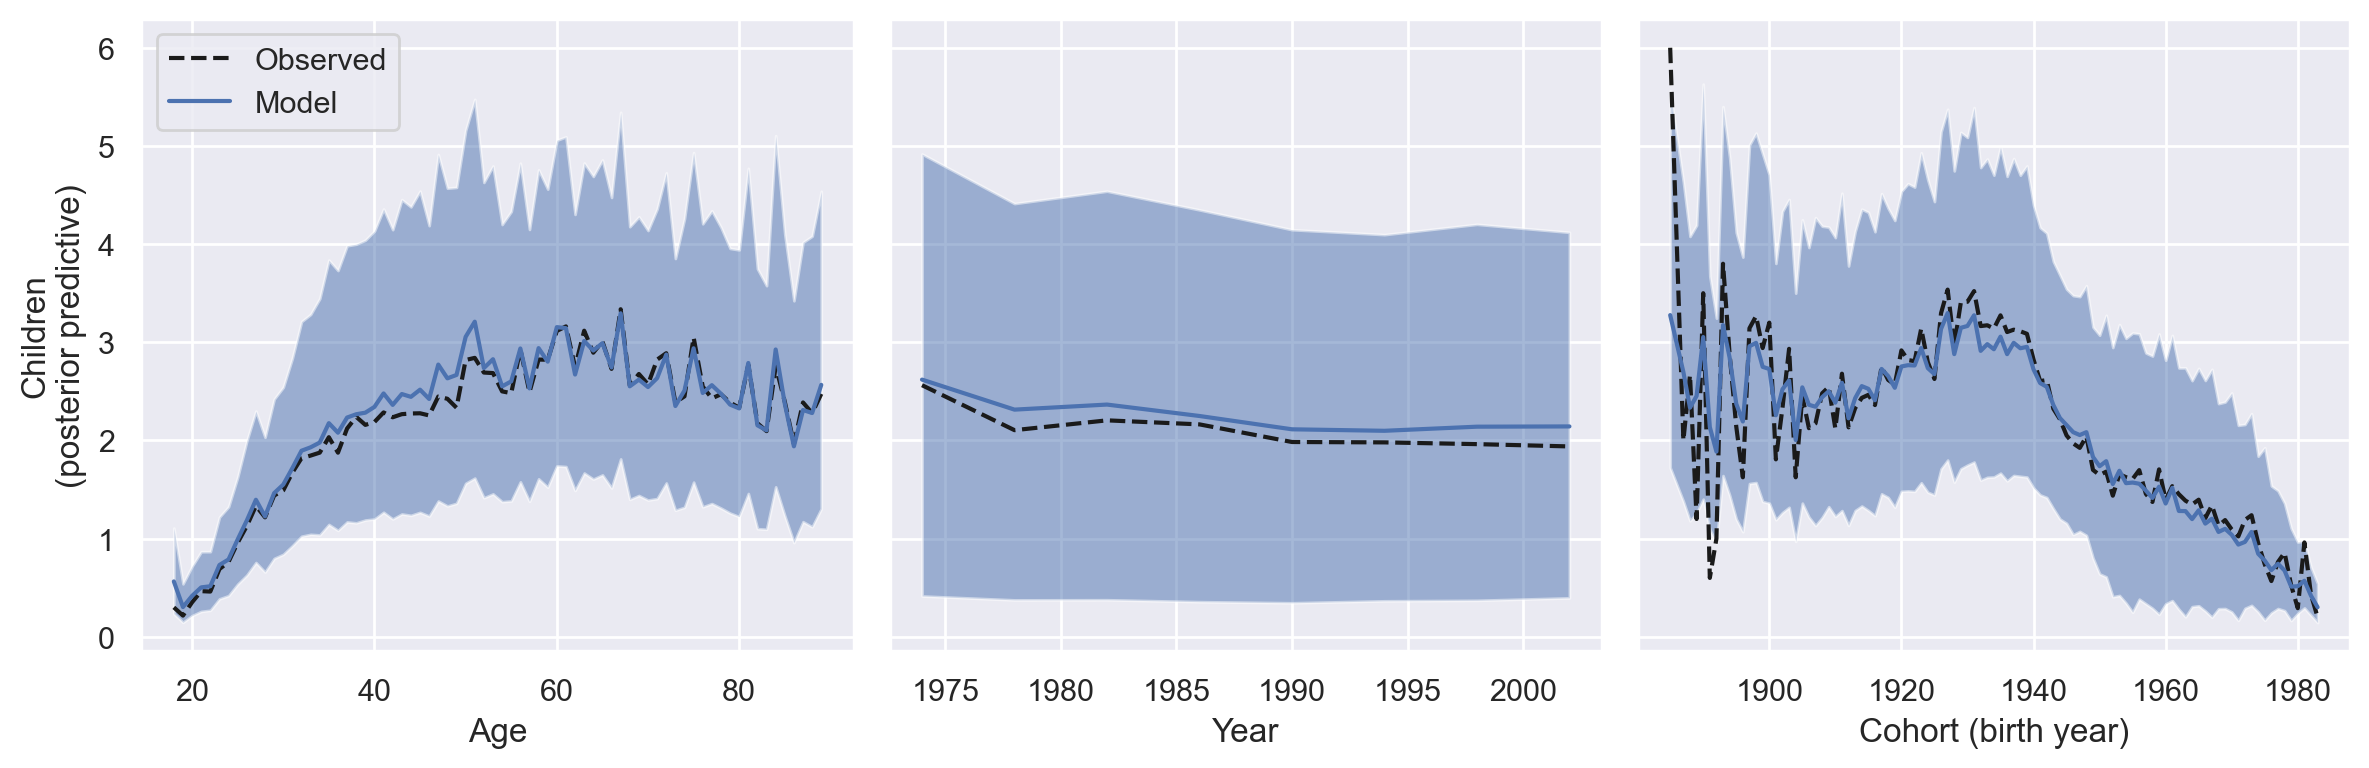

In [28]:
CI_WIDTH = 0.95

fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(12, 4))

# age

(df.groupby("age")["kids"].mean()
        .plot(c="k", ls="--", label="Observed", ax=axes[0]))

nc_pp_by_age = (
    nc_trace.posterior_predictive
            .assign_coords(kids_dim_2 = apc_df.index.get_level_values("age").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_2")
)

axes[0].fill_between(age_map,
                     nc_pp_by_age.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     nc_pp_by_age.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     alpha=0.5);
axes[0].plot(age_map, nc_pp_by_age.mean(dim=("chain", "draw", "kids_dim_2")), label="Model");


axes[0].set_xlabel("Age");
axes[0].set_ylabel("Children\n(posterior predictive)");

axes[0].legend(loc="upper left");

# year

(df.groupby("year")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", ax=axes[1]));

nc_pp_by_year = (
    nc_trace.posterior_predictive
            .assign_coords(kids_dim_2=apc_df.index.get_level_values("year").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_2")
)

axes[1].fill_between(year_map,
                     nc_pp_by_year.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     nc_pp_by_year.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     alpha=0.5);
axes[1].plot(year_map, nc_pp_by_year.mean(dim=("chain", "draw", "kids_dim_2")));

axes[1].set_xlabel("Year");

# cohort


(df.groupby("cohort")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", ax=axes[2]));

nc_pp_by_cohort = (
    nc_trace.posterior_predictive
            .assign_coords(kids_dim_2=apc_df.index.get_level_values("cohort").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_2")
)

axes[2].fill_between(cohort_map,
                     nc_pp_by_cohort.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     nc_pp_by_cohort.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     alpha=0.5);
axes[2].plot(cohort_map, nc_pp_by_cohort.mean(dim=("chain", "draw", "kids_dim_2")));


axes[2].set_xlabel("Cohort (birth year)");

fig.tight_layout();

In [29]:
def noncentered_normal_rw(name, *, dims):    
    innov = pm.Normal(f"innov_{name}", 0, 1, dims=dims)
    σ = pm.HalfNormal(f"σ_{name}", 2.5 * HALFNORMAL_SCALE)
    
    return pm.Deterministic(name, innov.cumsum() * σ, dims=dims)

In [30]:
with pm.Model(coords=coords) as rw_model:
    η0 = pm.Normal("η0", 0, 2.5)
    
    α = noncentered_normal_rw("α", dims="age")
    β = noncentered_normal_rw("β", dims="year")
    γ = noncentered_normal_rw("γ", dims="cohort")
    
    η = η0 + α[i] + β[j] + γ[k]
    
    N_ = pm.MutableData("N", N)
    ν = pm.HalfNormal("ν", 2.5)
    pm.NegativeBinomial("kids", N_ * pm.math.exp(η), ν, observed=kids)
    
    rw_trace = pm.sample(target_accept=0.95, chains = 4,  cores = 4, idata_kwargs={'log_likelihood':True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η0, innov_α, σ_α, innov_β, σ_β, innov_γ, σ_γ, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 190 seconds.


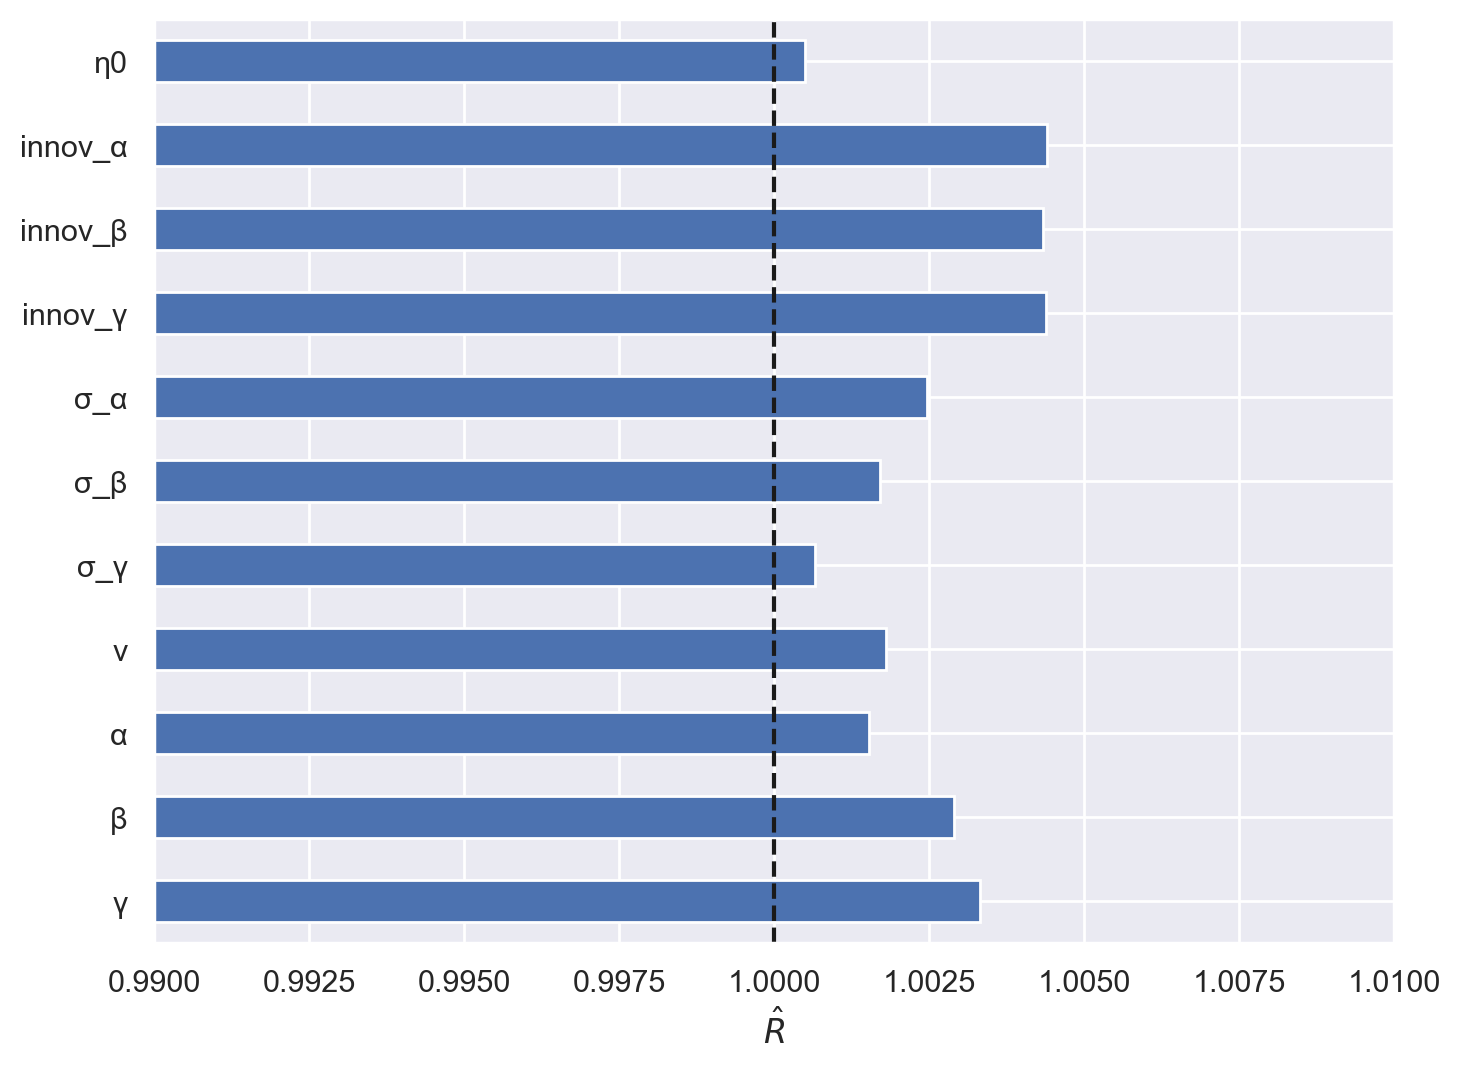

In [31]:
rw_rhat = az.rhat(rw_trace)

ax = (rw_rhat.max()
             .to_array()
             .to_series()
             .plot(kind="barh"))
ax.axvline(1, c="k", ls="--");

ax.set_xlim(0.99, 1.01);
ax.set_xlabel(r"$\hat{R}$");

ax.invert_yaxis();
ax.set_ylabel(None);

In [32]:
with rw_model:
    pm.set_data({"N": np.full_like(N, N_PP)})
    rw_trace.extend(pm.sample_posterior_predictive(rw_trace))

Sampling: [kids]


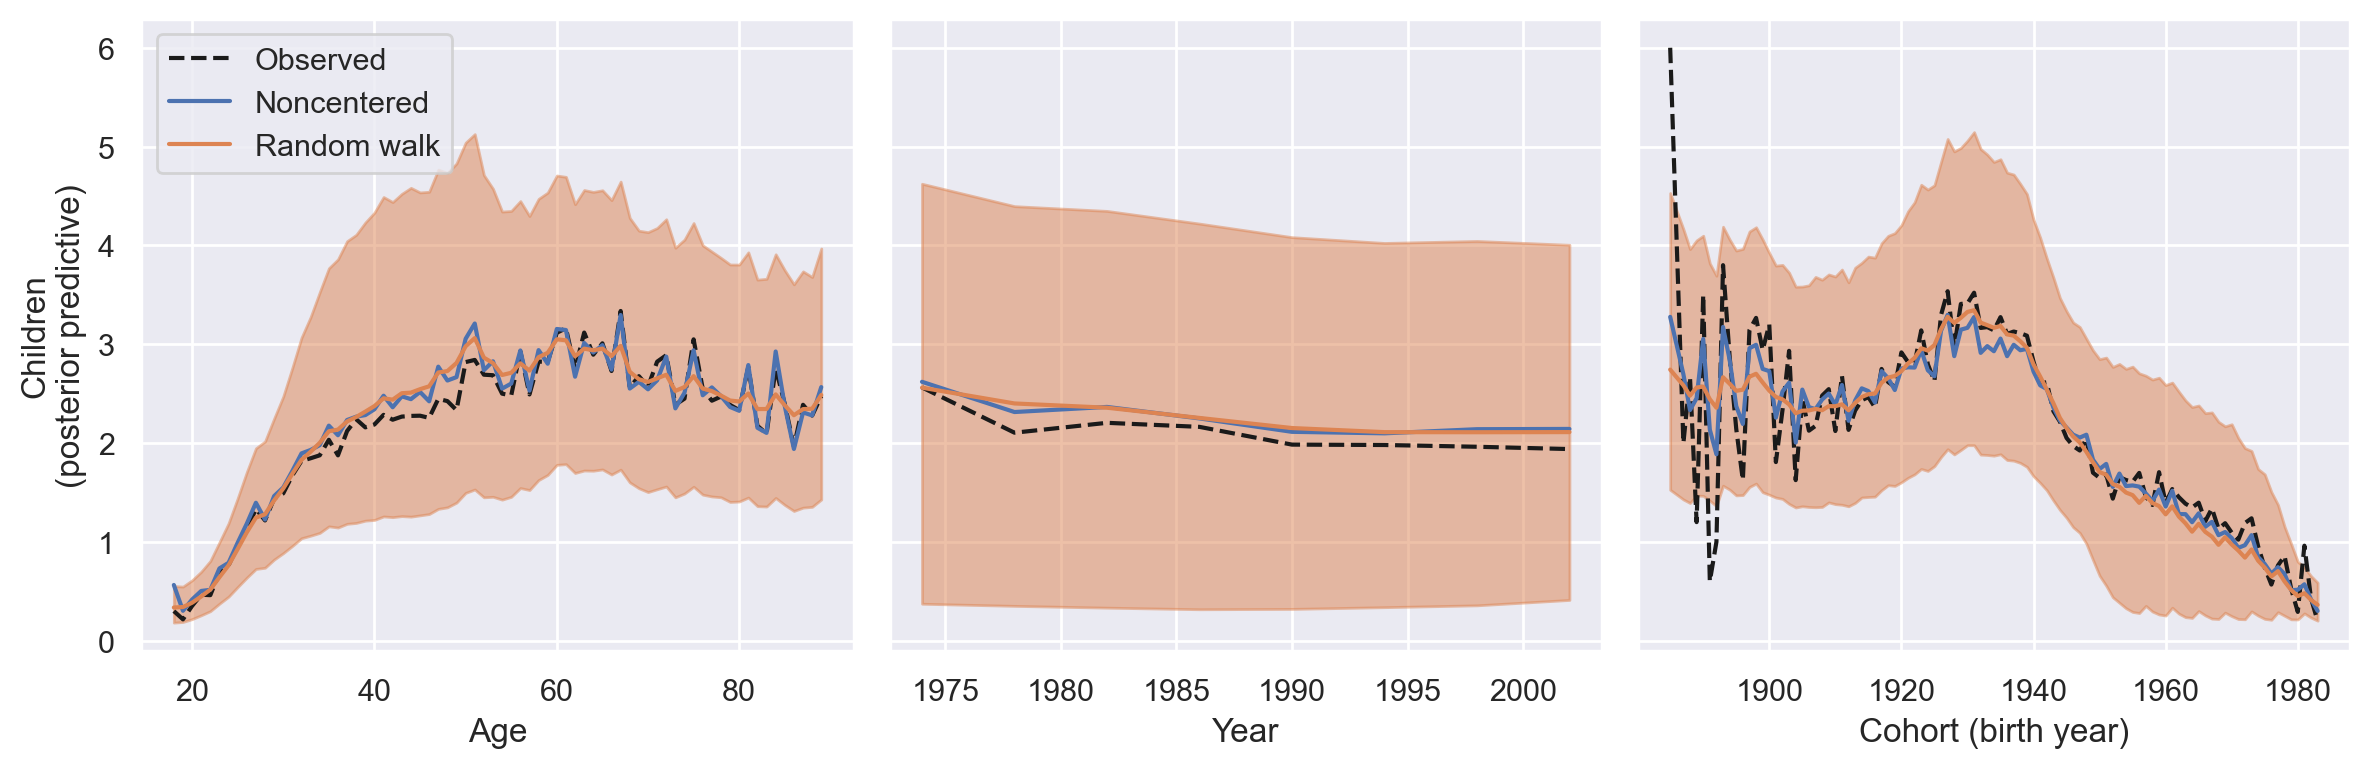

In [33]:
fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(12, 4))

# age

(df.groupby("age")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", label="Observed", ax=axes[0]))

rw_pp_by_age = (
    rw_trace.posterior_predictive
            .assign_coords(kids_dim_2=apc_df.index.get_level_values("age").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_2")
)

axes[0].fill_between(age_map,
                     rw_pp_by_age.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     rw_pp_by_age.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     alpha=0.5, color="C1");
axes[0].plot(age_map, nc_pp_by_age.mean(dim=("chain", "draw", "kids_dim_2")),
             label="Noncentered");
axes[0].plot(age_map, rw_pp_by_age.mean(dim=("chain", "draw", "kids_dim_2")),
             c="C1", label="Random walk");


axes[0].set_xlabel("Age");
axes[0].set_ylabel("Children\n(posterior predictive)");

axes[0].legend(loc="upper left");

# year

(df.groupby("year")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", ax=axes[1]));

rw_pp_by_year = (
    rw_trace.posterior_predictive
            .assign_coords(kids_dim_2=apc_df.index.get_level_values("year").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_2")
)

axes[1].fill_between(year_map,
                     rw_pp_by_year.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     rw_pp_by_year.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     alpha=0.5, color="C1");
axes[1].plot(year_map, nc_pp_by_year.mean(dim=("chain", "draw", "kids_dim_2")));
axes[1].plot(year_map, rw_pp_by_year.mean(dim=("chain", "draw", "kids_dim_2")),
             c="C1");

axes[1].set_xlabel("Year");

# cohort

(df.groupby("cohort")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", ax=axes[2]));

rw_pp_by_cohort = (
    rw_trace.posterior_predictive
            .assign_coords(kids_dim_2=apc_df.index.get_level_values("cohort").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_2")
)

axes[2].fill_between(cohort_map,
                     rw_pp_by_cohort.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     rw_pp_by_cohort.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     alpha=0.5, color="C1");
axes[2].plot(cohort_map, nc_pp_by_cohort.mean(dim=("chain", "draw", "kids_dim_2")));
axes[2].plot(cohort_map, rw_pp_by_cohort.mean(dim=("chain", "draw", "kids_dim_2")),
             c="C1");

axes[2].set_xlabel("Cohort (birth year)");

fig.tight_layout();

In [34]:
traces = {
    "Noncentered": nc_trace,
    "Random walk": rw_trace
}

comp_df = pm.compare(traces)
comp_df

/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Random walk,0,-1903.834632,29.968537,0.000000,1.000000e+00,16.353829,0.000000,False,log
Noncentered,1,-1961.282137,73.870823,57.447505,1.098499e-11,16.470564,5.325847,True,log


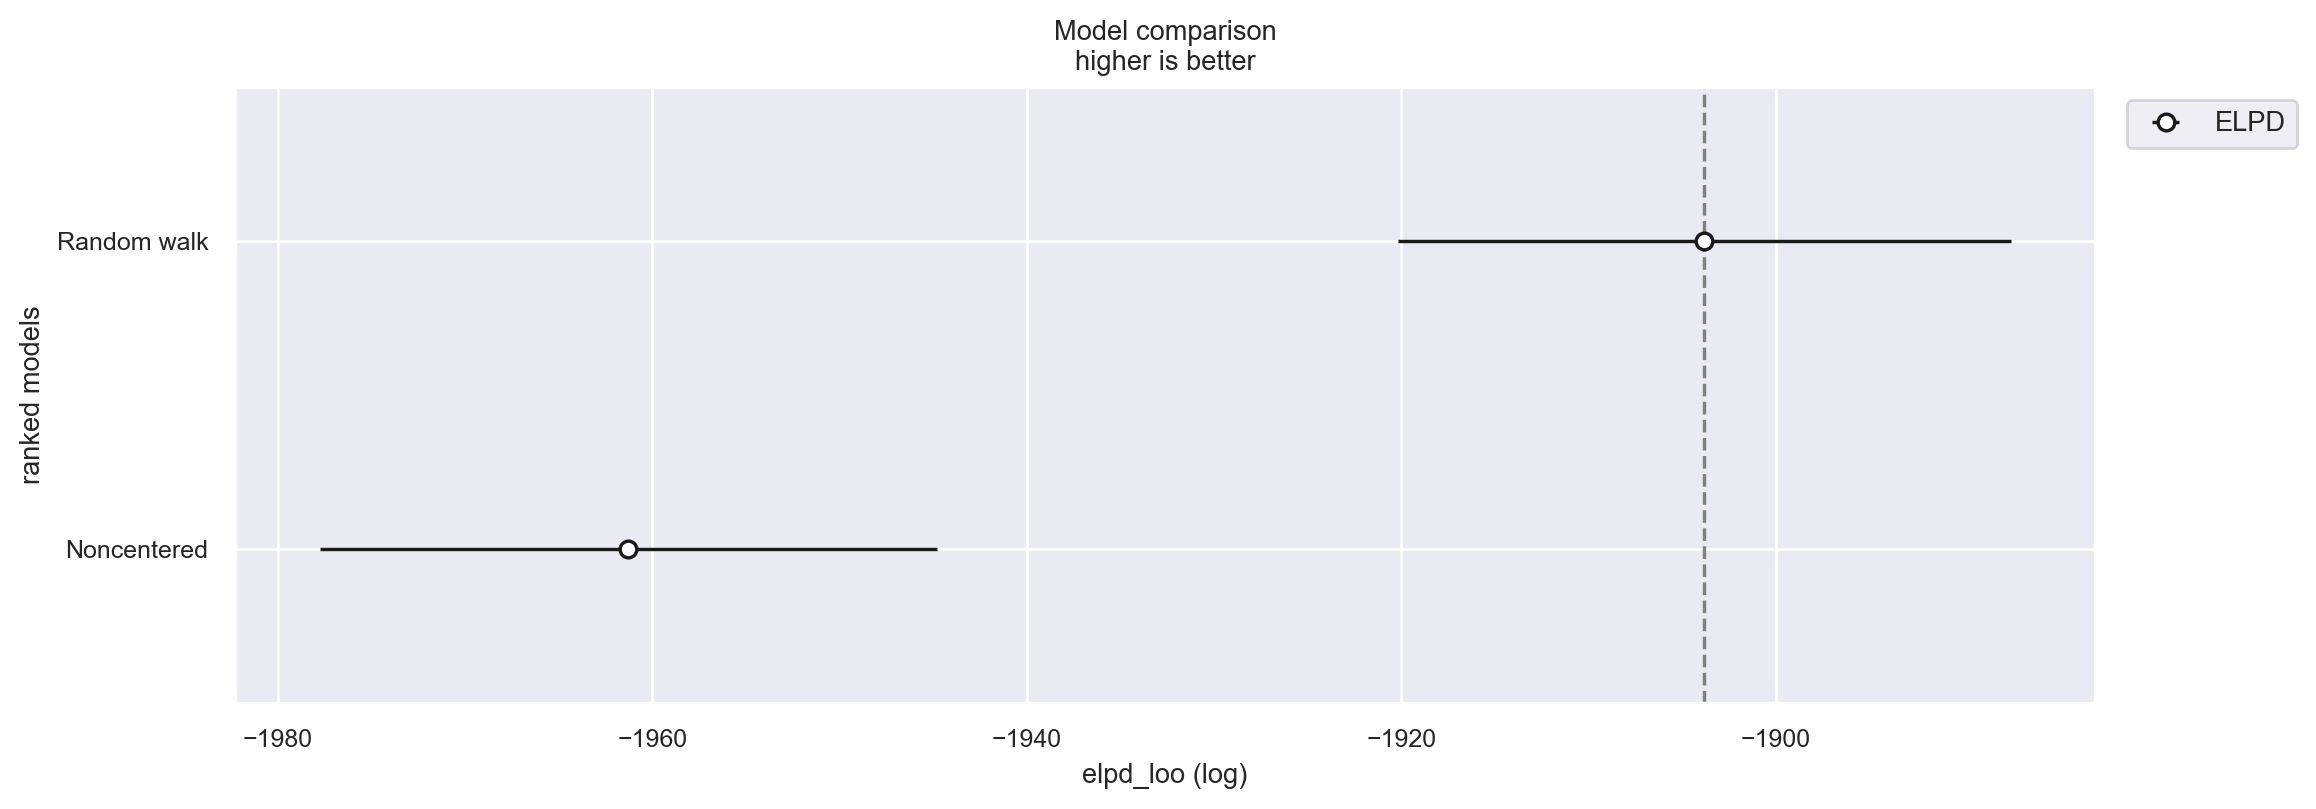

In [35]:
fig, ax = plt.subplots(figsize=(12, 4))

az.plot_compare(comp_df, insample_dev=False, plot_ic_diff=False,
                textsize=9, ax=ax);

## Сглаживание сплайнами

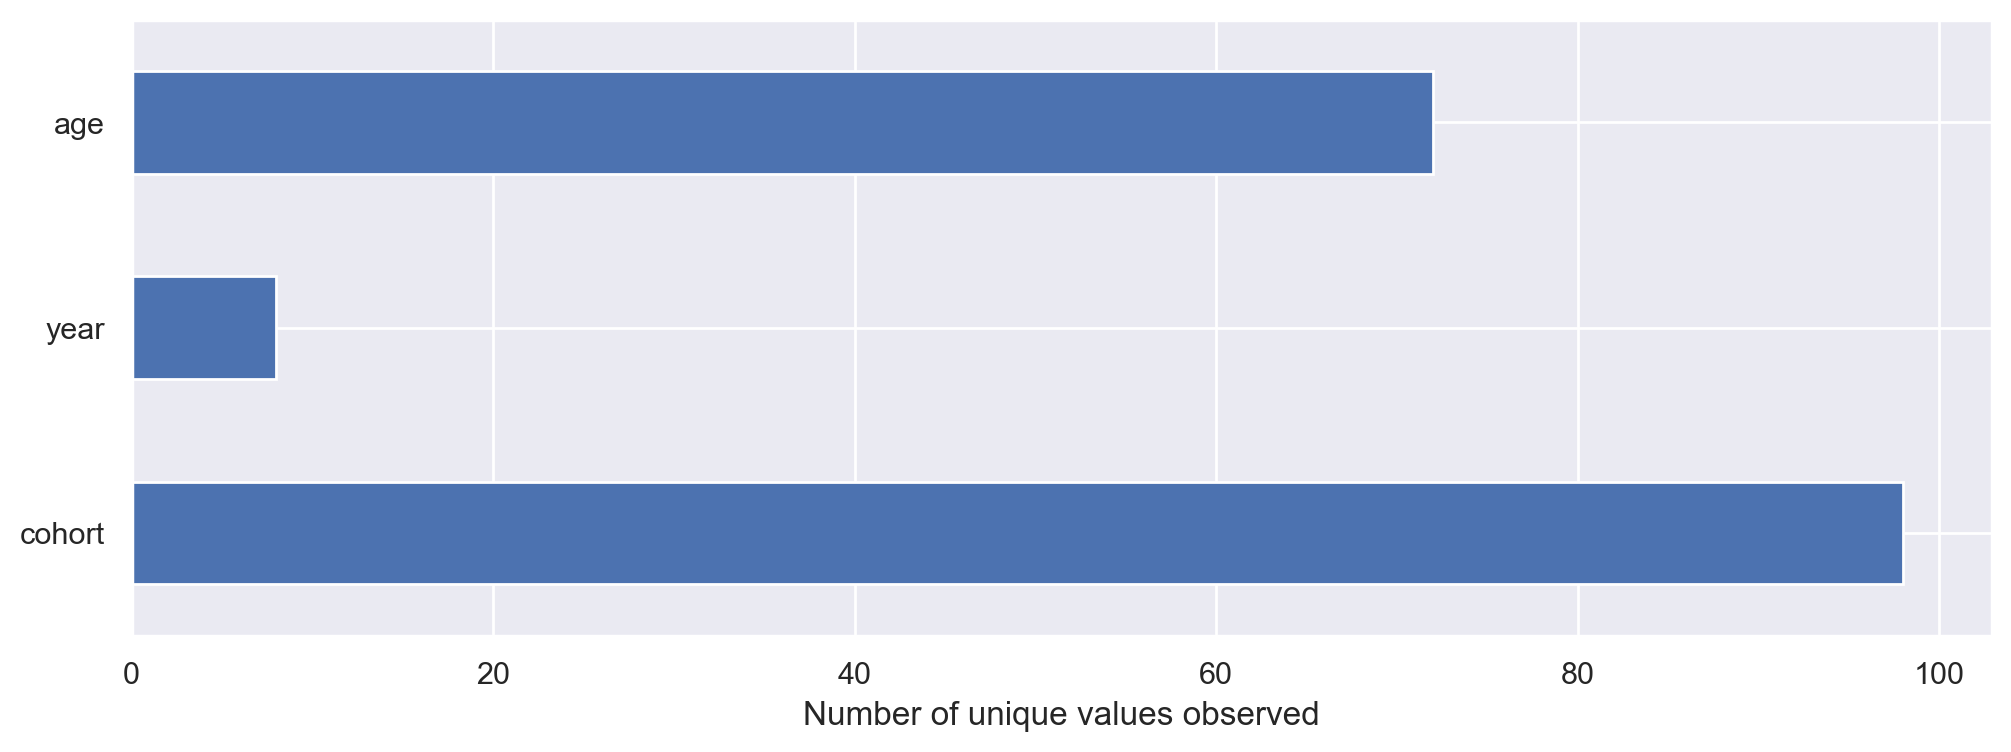

In [36]:
fig, axes = plt.subplots(figsize=(12, 4))
axes = (df[["age", "year", "cohort"]]
         .nunique()
         .plot(kind="barh"))

axes.set_xlabel("Number of unique values observed");
axes.invert_yaxis();

In [37]:
N_KNOT = 10
k = 2

In [38]:
age_knots = np.linspace(15, 96, N_KNOT)
age_dmat = sp.interpolate.BSpline(age_knots, np.eye(N_KNOT), k)(
    apc_df.index.get_level_values("age").values
)

In [39]:
cohort_knots = np.linspace(1885, 1986, N_KNOT)
cohort_dmat = sp.interpolate.BSpline(cohort_knots, np.eye(N_KNOT), k)(
    apc_df.index.get_level_values("cohort").values
)

In [40]:
spline_coords = {
    "age_knot": np.arange(N_KNOT),
    "year": year_map,
    "cohort_knot": np.arange(N_KNOT)
}

In [56]:
with pm.Model(coords=spline_coords) as spline_model:
    η0 = pm.Normal("η0", 0, 2.5)
    
    α = noncentered_normal_rw("α", dims="age_knot") / np.sqrt(N_KNOT)
    β = noncentered_normal_rw("β", dims="year")
    γ = noncentered_normal_rw("γ", dims="cohort_knot") / np.sqrt(N_KNOT)
    
    η = η0 + pm.math.dot(age_dmat, α) + β[j] + pm.math.dot(cohort_dmat, γ)
    
    N_ = pm.MutableData("N", N)
    ν = pm.HalfNormal("ν", 2.5)
    pm.NegativeBinomial("kids", N_ * pm.math.exp(η), ν, observed=kids)
    
    spline_trace = pm.sample(target_accept=0.98, chains = 4,  cores = 4, idata_kwargs={'log_likelihood':True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η0, innov_α, σ_α, innov_β, σ_β, innov_γ, σ_γ, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 286 seconds.


In [57]:
with spline_model:
    pm.set_data({"N": np.full_like(N, N_PP)})
    spline_trace.extend(pm.sample_posterior_predictive(spline_trace))

Sampling: [kids]


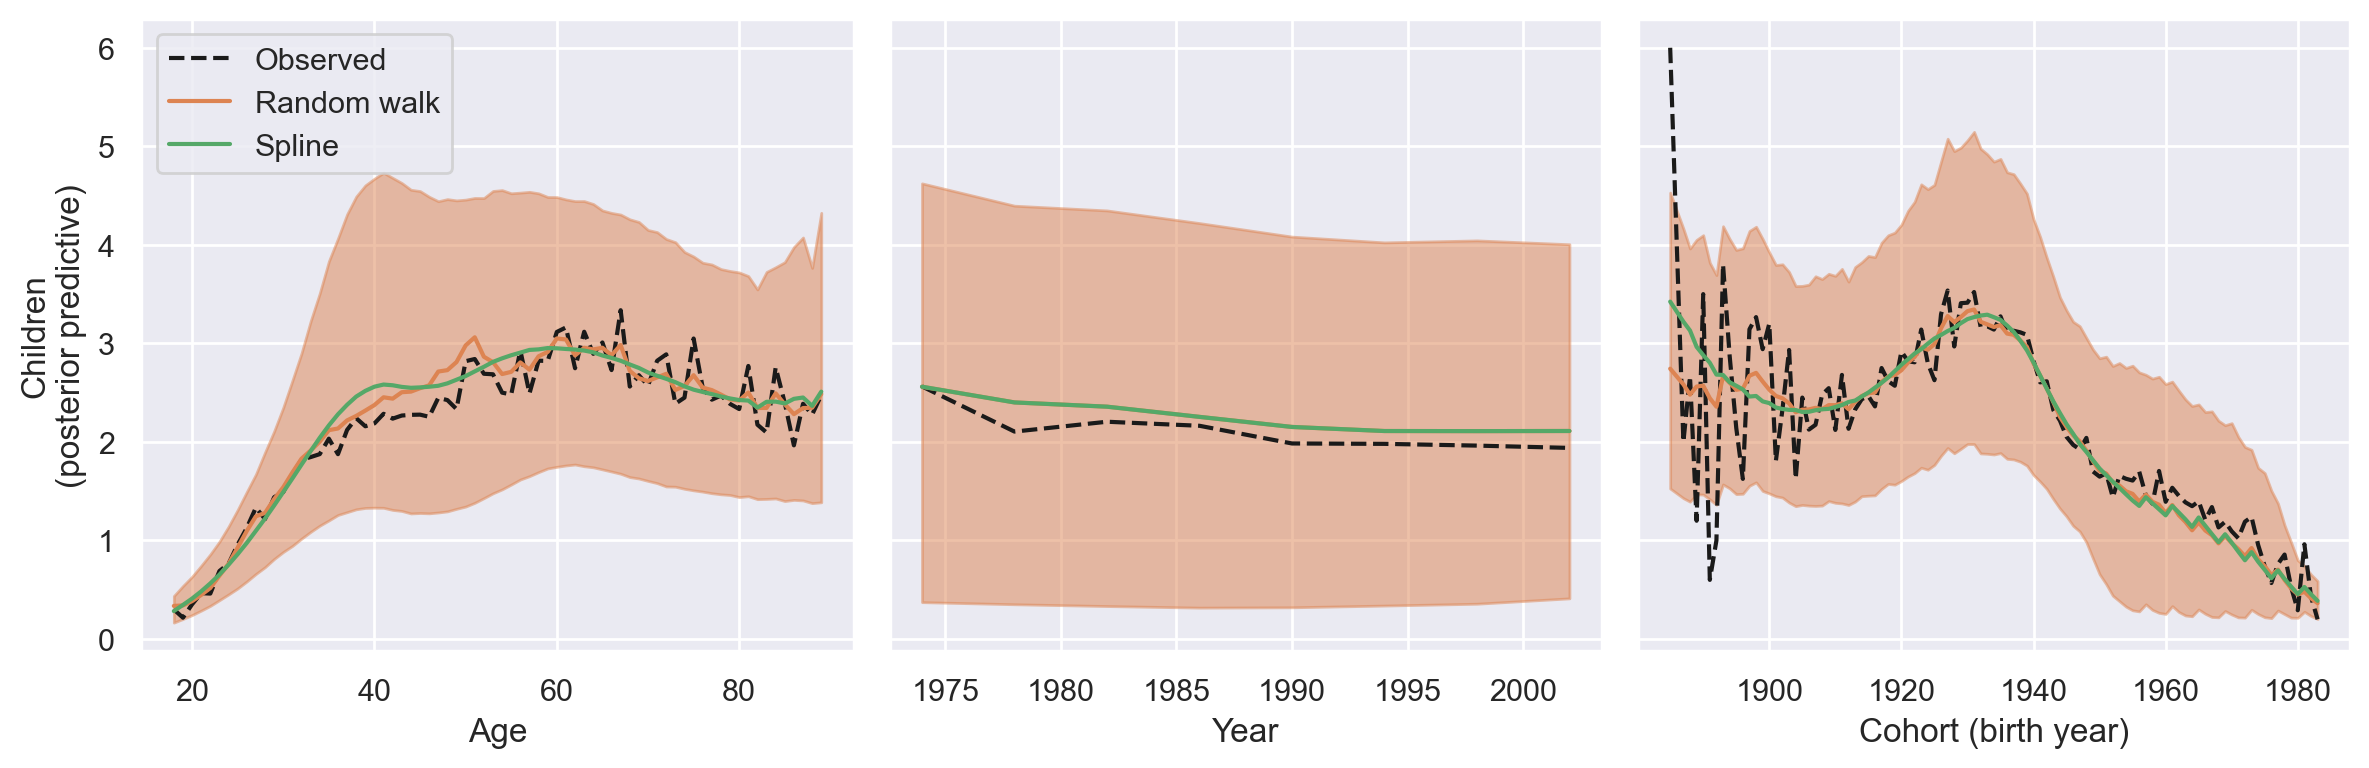

In [58]:
fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(12, 4))

# age

(df.groupby("age")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", label="Observed", ax=axes[0]))

spline_pp_by_age = (
    spline_trace.posterior_predictive
            .assign_coords(kids_dim_2=apc_df.index.get_level_values("age").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_2")
)

axes[0].fill_between(age_map,
                     spline_pp_by_age.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     spline_pp_by_age.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     alpha=0.5, color="C1");
axes[0].plot(age_map, rw_pp_by_age.mean(dim=("chain", "draw", "kids_dim_2")),
             c="C1", label="Random walk");
axes[0].plot(age_map, spline_pp_by_age.mean(dim=("chain", "draw", "kids_dim_2")),
             c="C2", label="Spline");


axes[0].set_xlabel("Age");
axes[0].set_ylabel("Children\n(posterior predictive)");

axes[0].legend(loc="upper left");

# year

(df.groupby("year")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", ax=axes[1]));

spline_pp_by_year = (
    rw_trace.posterior_predictive
            .assign_coords(kids_dim_2=apc_df.index.get_level_values("year").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_2")
)

axes[1].fill_between(year_map,
                     spline_pp_by_year.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     spline_pp_by_year.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     alpha=0.5, color="C1");
axes[1].plot(year_map, rw_pp_by_year.mean(dim=("chain", "draw", "kids_dim_2")), c="C1");
axes[1].plot(year_map, spline_pp_by_year.mean(dim=("chain", "draw", "kids_dim_2")),
             c="C2");

axes[1].set_xlabel("Year");

# cohort

(df.groupby("cohort")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", ax=axes[2]));

spline_pp_by_cohort = (
    spline_trace.posterior_predictive
            .assign_coords(kids_dim_2=apc_df.index.get_level_values("cohort").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_2")
)

axes[2].fill_between(cohort_map,
                     rw_pp_by_cohort.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     rw_pp_by_cohort.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     alpha=0.5, color="C1");
axes[2].plot(cohort_map, rw_pp_by_cohort.mean(dim=("chain", "draw", "kids_dim_2")),  c="C1");
axes[2].plot(cohort_map, spline_pp_by_cohort.mean(dim=("chain", "draw", "kids_dim_2")),
             c="C2");

axes[2].set_xlabel("Cohort (birth year)");

fig.tight_layout();

In [59]:
traces["Spline"] = spline_trace
comp_df = pm.compare(traces)
comp_df

/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Spline,0,-1897.639081,10.657962,0.000000,9.757786e-01,16.410206,0.000000,False,log
Random walk,1,-1903.834632,29.968537,6.195551,2.422135e-02,16.353829,3.609724,False,log
Noncentered,2,-1961.282137,73.870823,63.643056,5.041523e-13,16.470564,6.994651,True,log


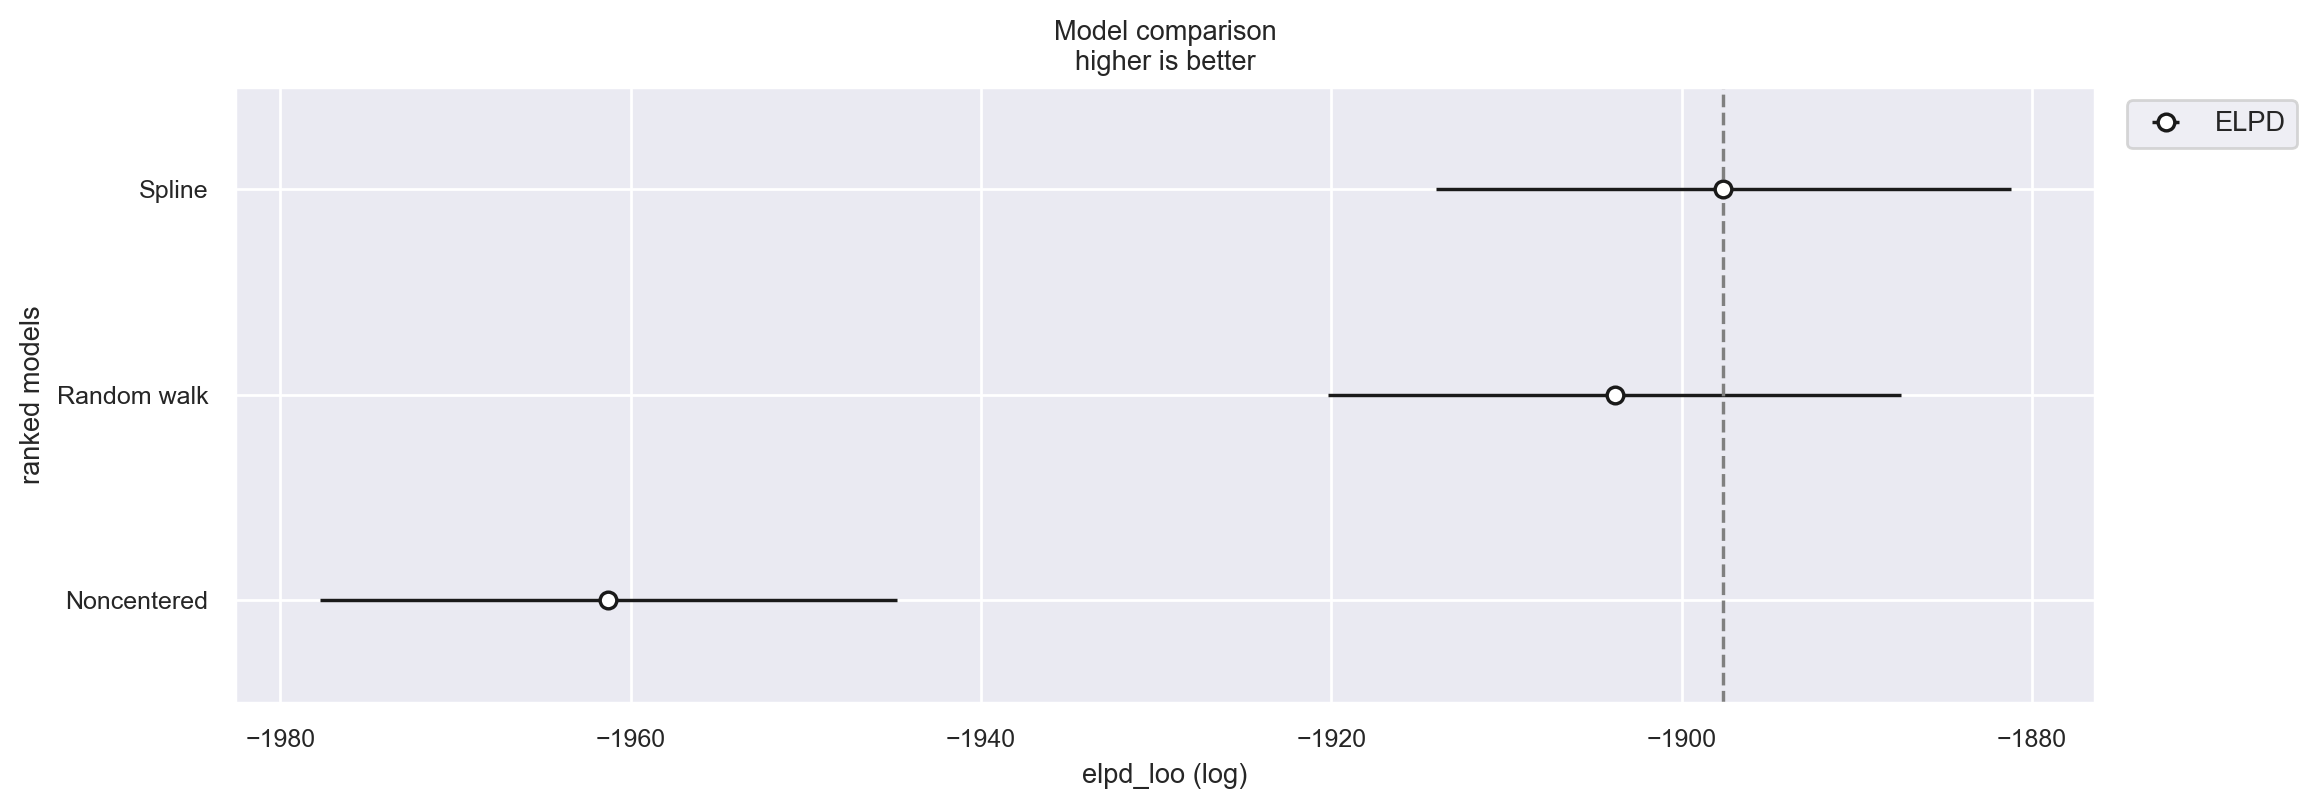

In [60]:
fig, ax = plt.subplots(figsize=(12, 4))

az.plot_compare(comp_df, insample_dev=False, plot_ic_diff=False,
                textsize=9, ax=ax);

Мы видим, что сплайновая модель является небольшим улучшением по сравнению с нецентрированной моделью нормального случайного блуждания с точки зрения нашей метрики LOO. 


## Зависимость возраста/когорты

С помощью этих пяти моделей мы прошли итерацию от неизвестной модели к моделям, которые были несколько лучше, но все еще имели плохой результат, и плавно подошли к моделям с хорошим результатом. 
Преодолев эти проблемы с помощью наших моделей, мы теперь переходим к вопросу о том, действительно ли полезно учитывать эффект периода (года)?

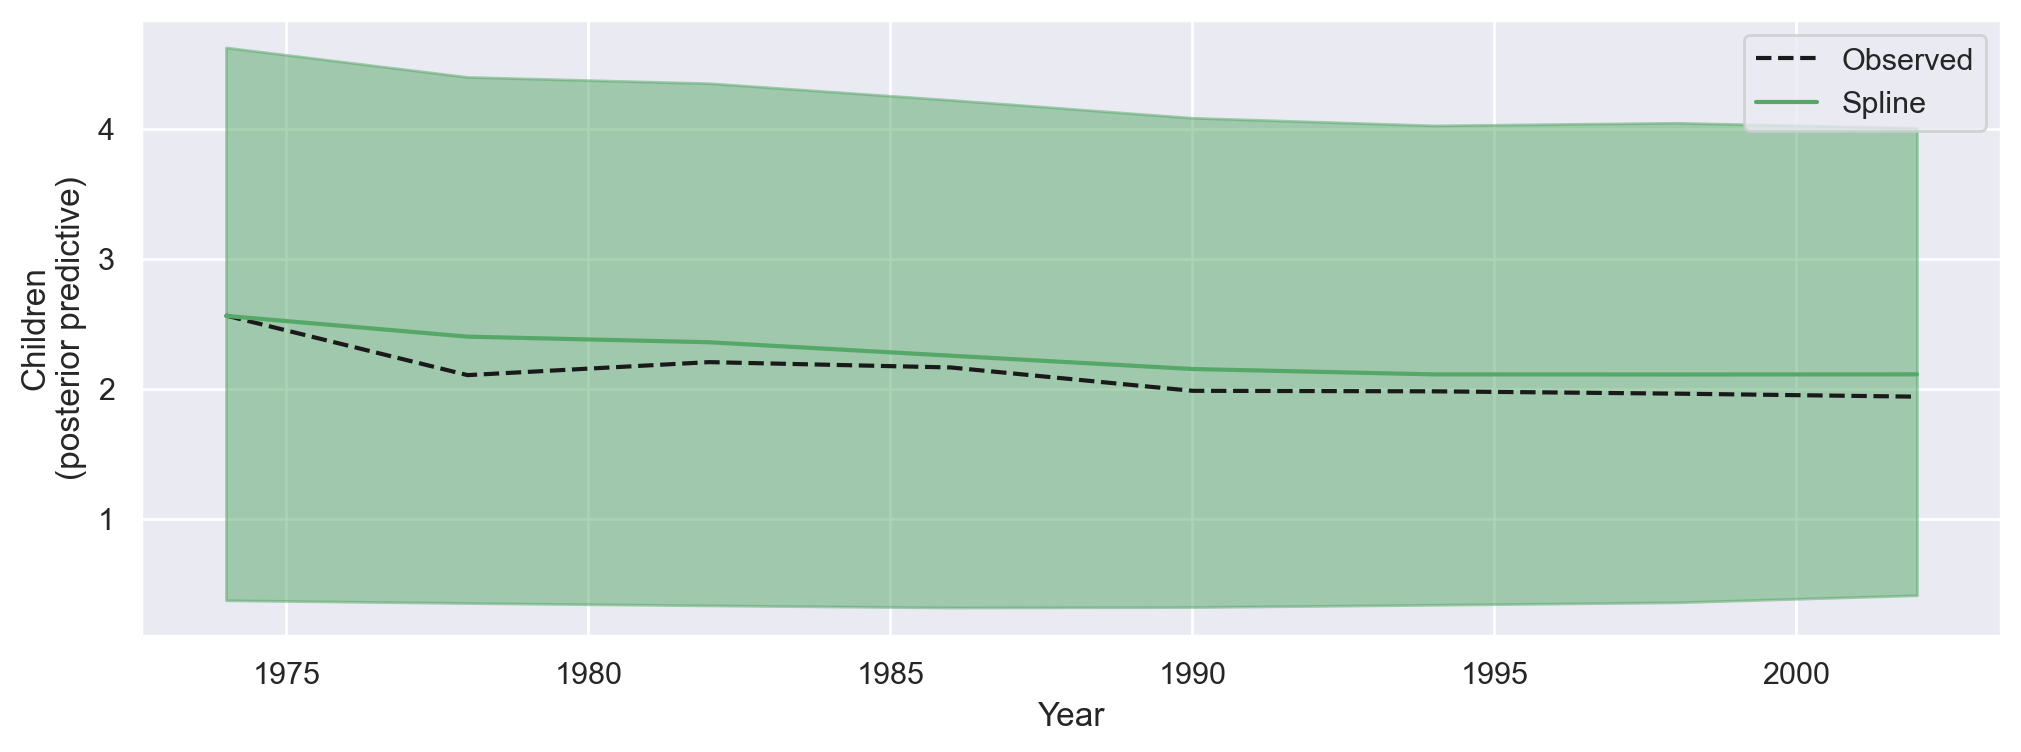

In [61]:
fig, ax = plt.subplots(figsize=(12, 4))

(df.groupby("year")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", label="Observed", ax=ax));

ax.fill_between(year_map,
                spline_pp_by_year.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                spline_pp_by_year.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                alpha=0.5, color="C2");
ax.plot(year_map, spline_pp_by_year.mean(dim=("chain", "draw", "kids_dim_2")),
             c="C2", label="Spline");

ax.set_xlabel("Year");
ax.set_ylabel("Children\n(posterior predictive)");
ax.legend();

Апостериорное предсказание эфекта периода на количество детей в предыдущей модели оказался довольно близким к константе, что дает нам основания подозревать, что он не может сильно способствовать точности прогнозирования модели. Теперь мы количественно оценим влияние удаления эффектов периода на точность прогнозирования нашей модели.

Для $\alpha_i$ и $\gamma_k$ мы используем те же априорные методы, что и сплайн-модель APC, но устанавливаем $\beta_k = 0$.

In [62]:
with pm.Model(coords=spline_coords) as ac_model:
    η0 = pm.Normal("η0", 0, 2.5)
    
    α = noncentered_normal_rw("α", dims="age_knot") / np.sqrt(age_knots.size)
    γ = noncentered_normal_rw("γ", dims="cohort_knot") / np.sqrt(cohort_knots.size)
    
    η = η0 + pm.math.dot(age_dmat, α) + pm.math.dot(cohort_dmat, γ)
    
    N_ = pm.MutableData("N", N)
    ν = pm.HalfNormal("ν", 2.5)
    pm.NegativeBinomial("kids", N_ * pm.math.exp(η), ν, observed=kids)
    
    ac_trace = pm.sample(target_accept=0.95, chains = 4,  cores = 4, idata_kwargs={'log_likelihood':True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η0, innov_α, σ_α, innov_γ, σ_γ, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 162 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


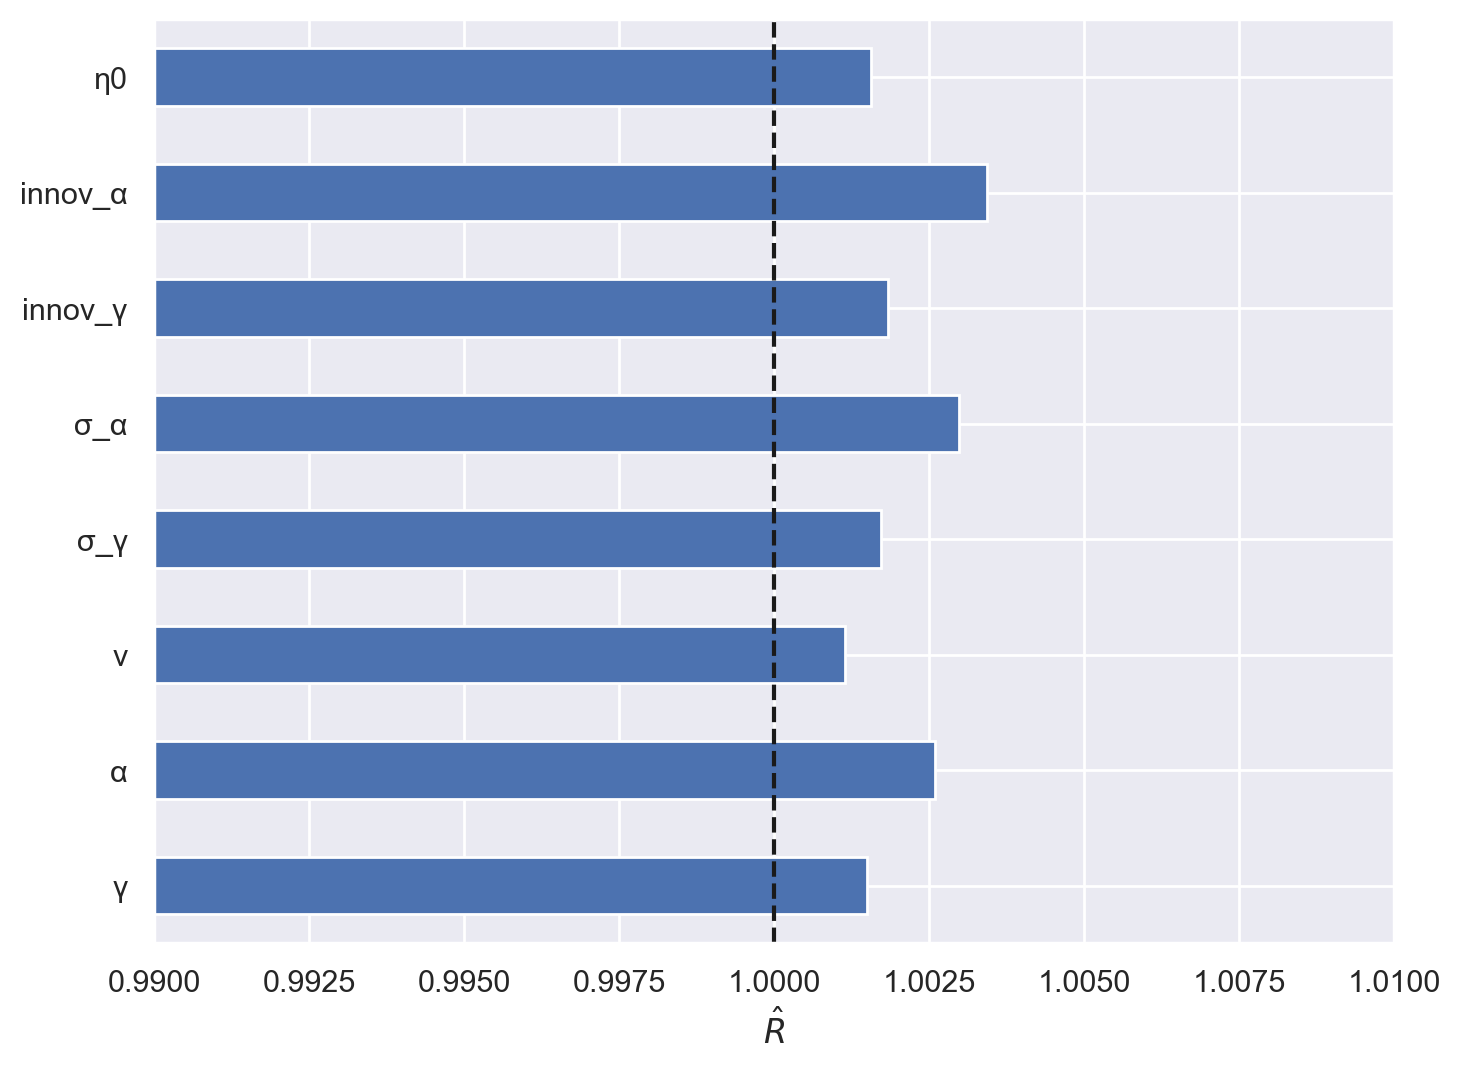

In [63]:
ac_rhat = az.rhat(ac_trace)
ax = (ac_rhat.max()
             .to_array()
             .to_series()
             .plot(kind="barh"))
ax.axvline(1, c="k", ls="--");

ax.set_xlim(0.99, 1.01);
ax.set_xlabel(r"$\hat{R}$");

ax.invert_yaxis();
ax.set_ylabel(None);

In [64]:
with ac_model:
    pm.set_data({"N": np.full_like(N, N_PP)})
    ac_trace.extend(pm.sample_posterior_predictive(ac_trace))

Sampling: [kids]


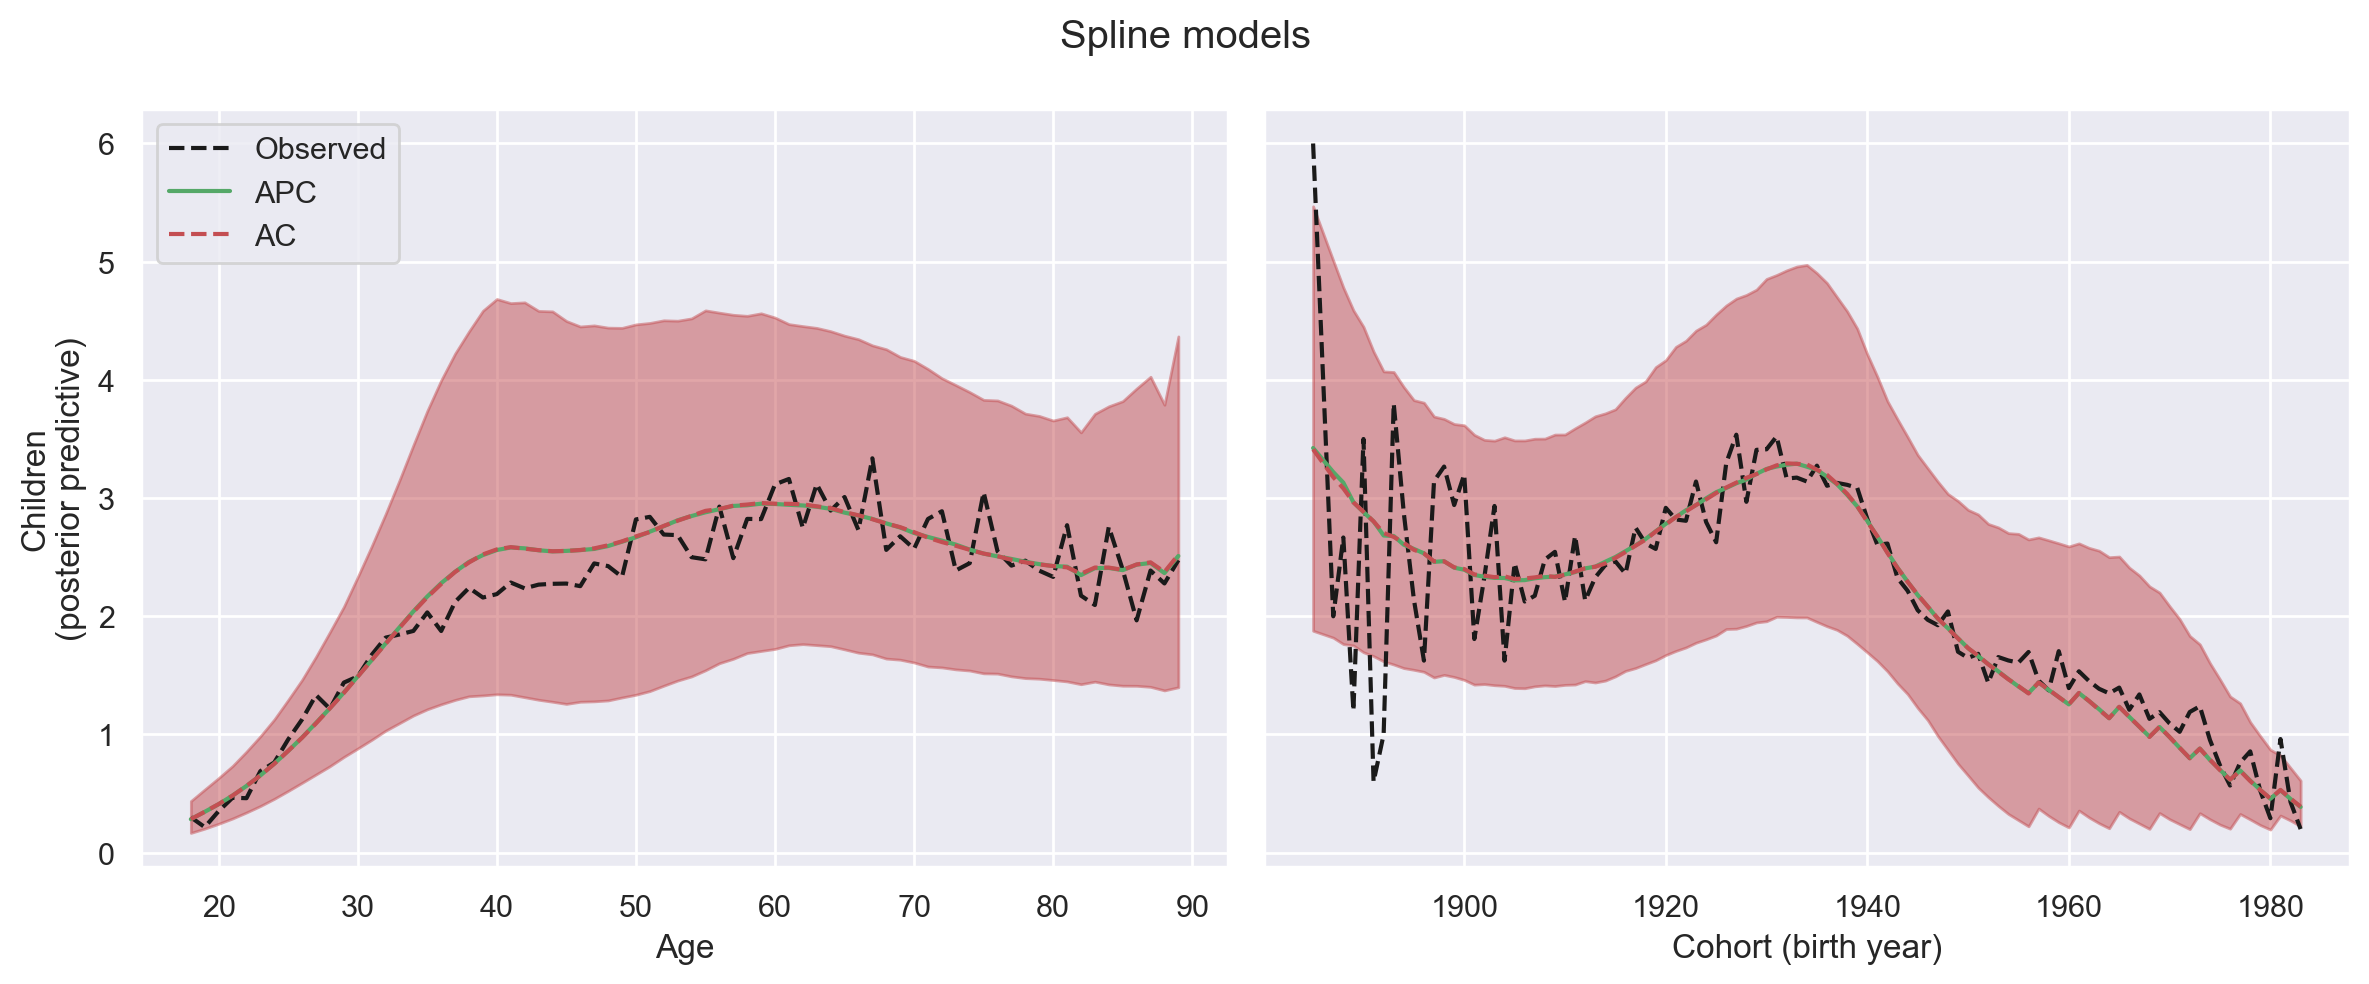

In [65]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))

# age

(df.groupby("age")
   ["kids"]
   .mean()
   .plot(c="k", ls="--", label="Observed", ax=axes[0]))

ac_pp_by_age = (
    ac_trace.posterior_predictive
            .assign_coords(kids_dim_2=apc_df.index.get_level_values("age").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_2")
)

axes[0].fill_between(age_map,
                     ac_pp_by_age.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     ac_pp_by_age.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     alpha=0.5, color="C3");
axes[0].plot(age_map, spline_pp_by_age.mean(dim=("chain", "draw", "kids_dim_2")),
             c="C2", label="APC");
axes[0].plot(age_map, ac_pp_by_age.mean(dim=("chain", "draw", "kids_dim_2")),
             c="C3", ls="--", label="AC");


axes[0].set_xlabel("Age");
axes[0].set_ylabel("Children\n(posterior predictive)");

axes[0].legend(loc="upper left");

# cohort

(df.groupby("cohort")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", ax=axes[1]));

ac_pp_by_cohort = (
    ac_trace.posterior_predictive
            .assign_coords(kids_dim_2=apc_df.index.get_level_values("cohort").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_2")
)

axes[1].fill_between(cohort_map,
                     ac_pp_by_cohort.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     ac_pp_by_cohort.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_2")),
                     alpha=0.5, color="C3");
axes[1].plot(cohort_map, spline_pp_by_cohort.mean(dim=("chain", "draw", "kids_dim_2")),
             c="C2");
axes[1].plot(cohort_map, ac_pp_by_cohort.mean(dim=("chain", "draw", "kids_dim_2")),
             c="C3", ls="--");

axes[1].set_xlabel("Cohort (birth year)");

fig.suptitle("Spline models");
fig.tight_layout();

Мы видим, что апостериорные прогнозы сплайн-моделей APC и AC визуально неотличимы.

In [66]:
spline_traces = {
    "APC": spline_trace,
    "AC": ac_trace
}
spline_comp_df = pm.compare(spline_traces)
spline_comp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
APC,0,-1897.639081,10.657962,0.000000,1.0,16.410206,0.000000,False,log
AC,1,-1898.365743,9.243925,0.726662,0.0,16.446409,0.943695,False,log


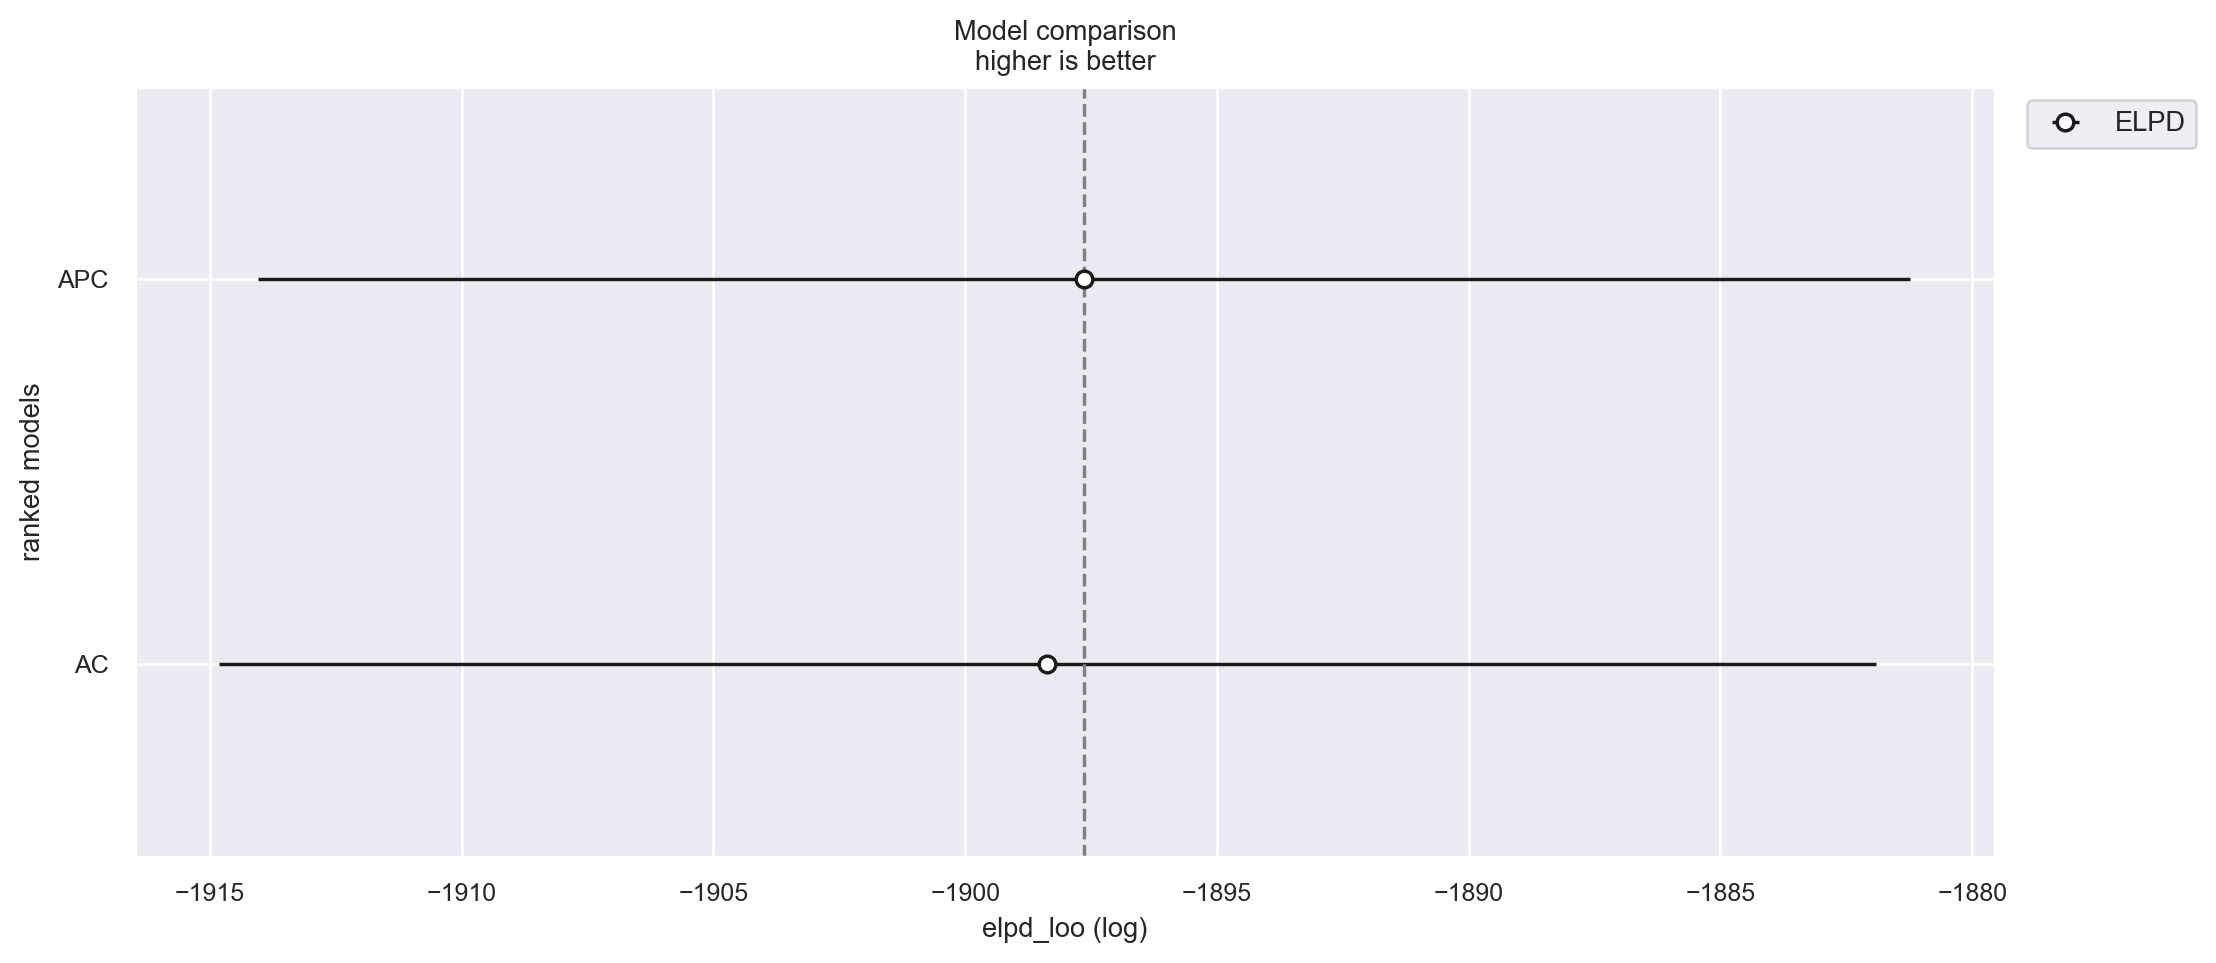

In [67]:
fig, ax = plt.subplots(figsize=(12, 5))
az.plot_compare(spline_comp_df, insample_dev=False, plot_ic_diff=False,
                textsize=9, ax=ax);


Сравнение сплайновых моделей APC и AC с помощью PSIS-LOO показывает, что они практически неотличимы, поэтому мы предпочитаем более простую модель AC. 

Модели, которые не учитывают период, имеют дополнительное преимущество в том, что их проще использовать при прогнозировании, поскольку нам не нужно выдвигать гипотезу о конкретной функциональной форме для будущих эффектов периода.

### Еще раз про плохие и хорошие цепочки

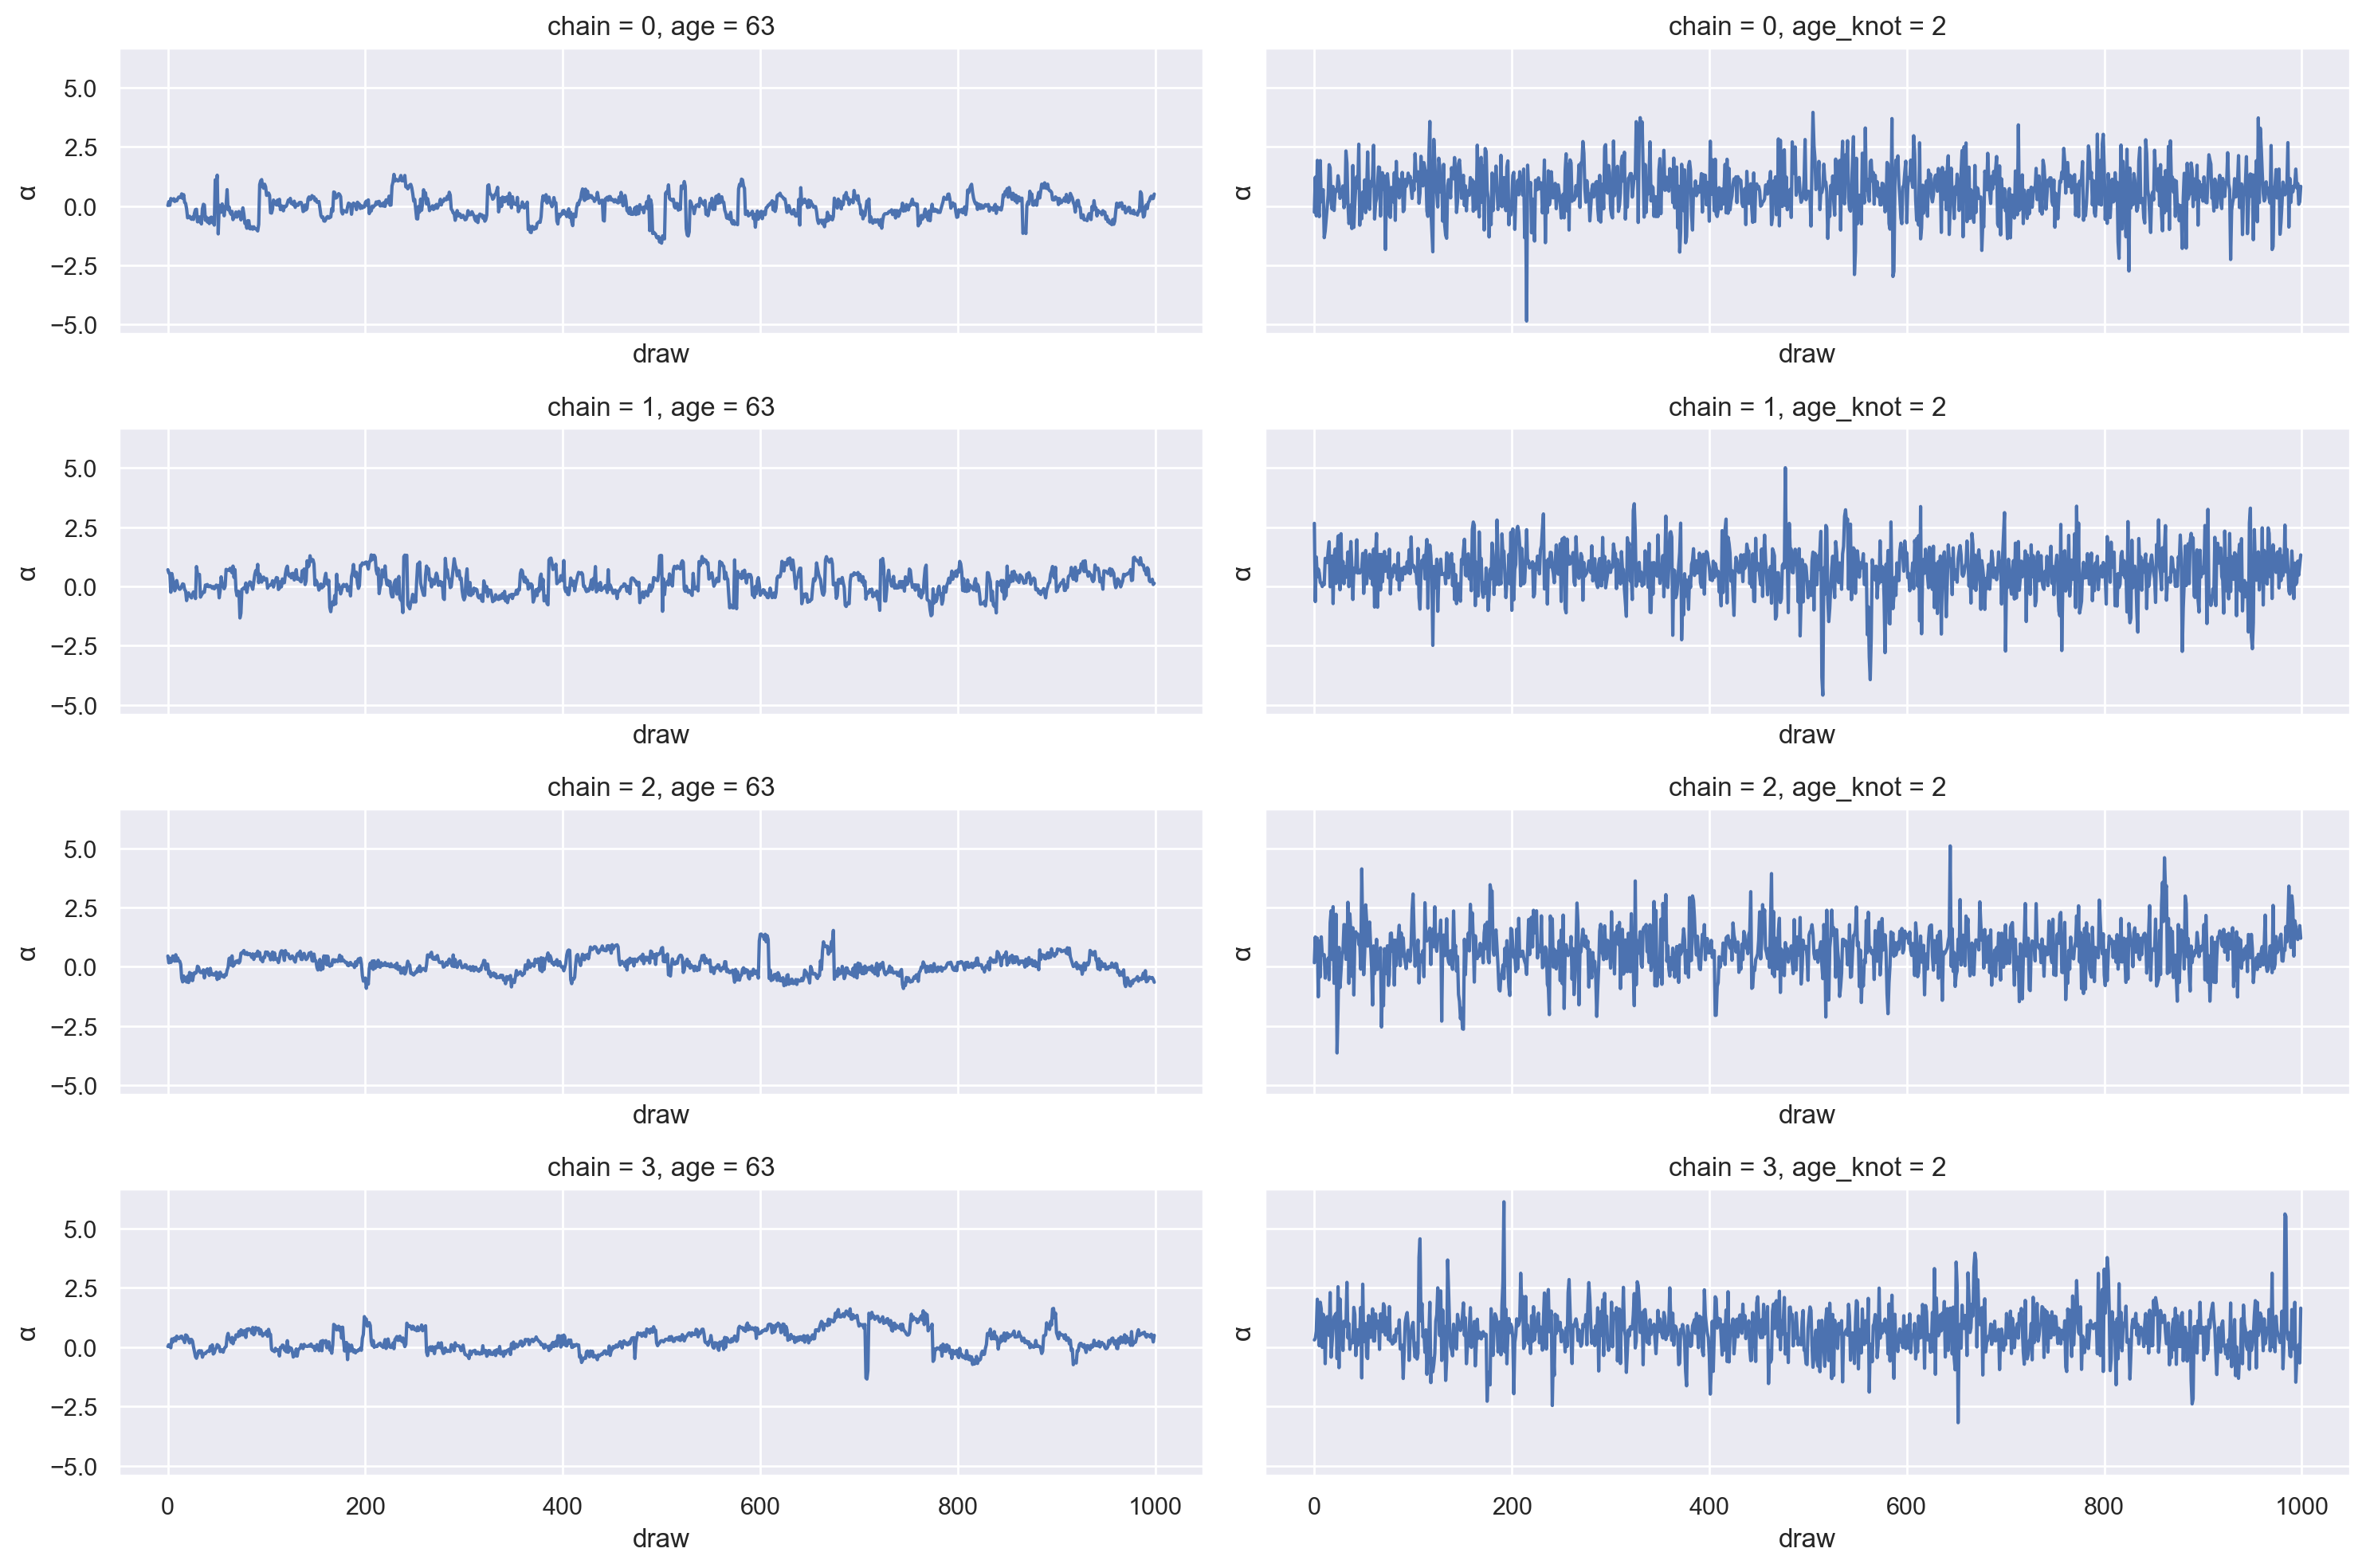

In [97]:
α_worst_norm_trace = norm_rhat["α"].idxmax()
α_worst_ac_trace = ac_rhat["α"].idxmax()



CHAINS = len(norm_trace.posterior['chain'].values)
fig, axes = plt.subplots(nrows=CHAINS, ncols=2, sharex=True, sharey=True, figsize=(15,10))

for chain, (ax, ay) in enumerate(axes):
    (norm_trace.posterior["α"]
               .sel(age=α_worst_norm_trace, chain=chain)
               .plot(ax=ax));
    (ac_trace.posterior["α"]
               .sel(age_knot=α_worst_ac_trace, chain=chain)
               .plot(ax=ay));
fig.tight_layout();